In [2]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import classifiers
from weighted_model import (
    FairTeacherStudentClassifier,
    TeacherStudentClassifier
)

# Import curriculum models
from curriculum_models import (
    CurriculumStudentTeacher,
    WeightedCurriculumStudentTeacher
)

# Import helpers
from helpers import (
    CurriculumHelper,
    FairnessEvaluatorHelper
)
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
np.random.seed(41) # Set seed for reproducibility
%load_ext autoreload
%autoreload 2

In [83]:
data = fetch_adult(as_frame=True)
df = data.frame
print(len(df))
df.head()


48842


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


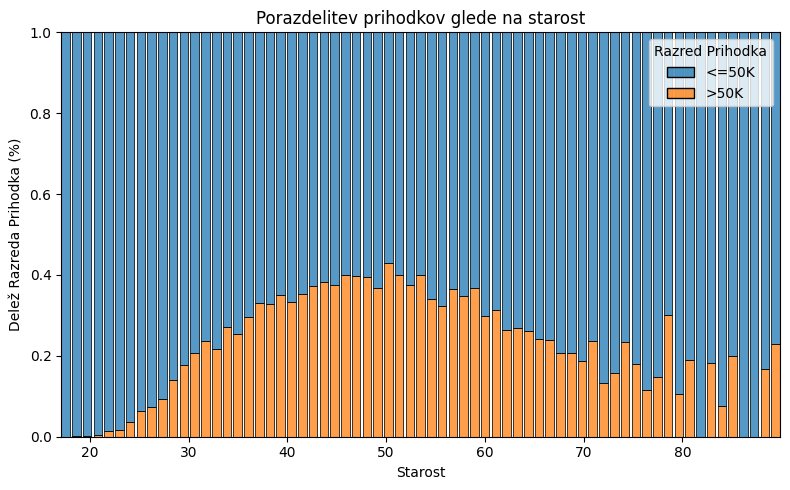

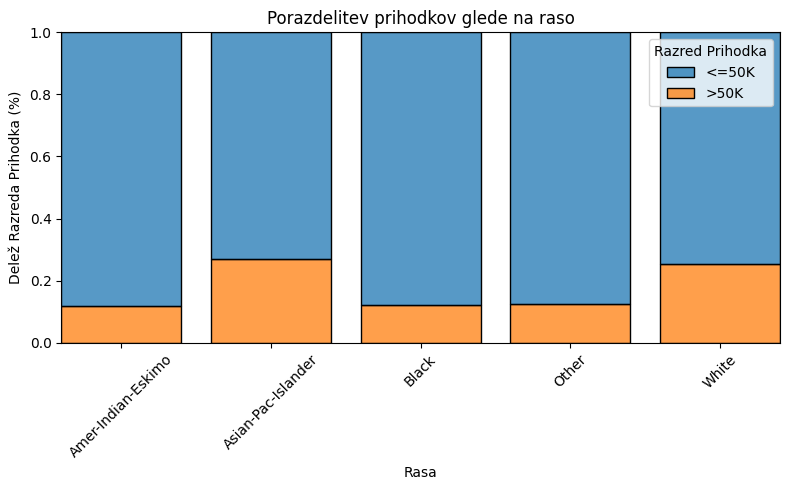

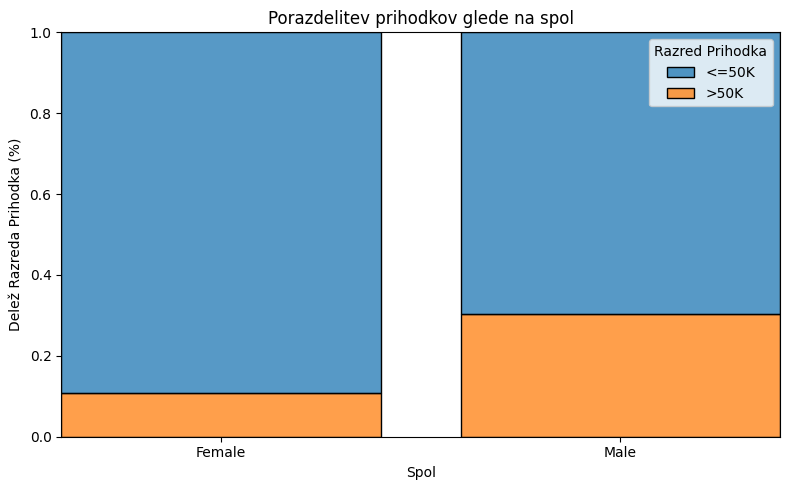

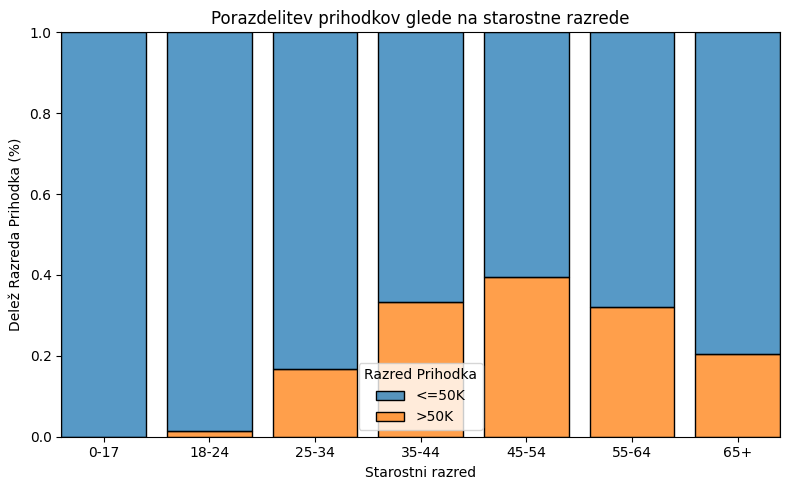

In [84]:
# Razdelitev starosti v razrede
df["age_class"] = pd.cut(
    df["age"],
    bins=[0, 18, 24, 34, 44, 54, 64, float("inf")],
    labels=["0-17", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"],
)

df["Razred Prihodka"]  = df["class"]

# Starost
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df, x="age", hue="Razred Prihodka", stat="probability", multiple="fill", shrink=0.8
)
plt.title("Porazdelitev prihodkov glede na starost")
plt.xlabel("Starost")
plt.ylabel("Delež Razreda Prihodka (%)")
plt.tight_layout()
plt.show()

# Rasa
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df, x="race", hue="Razred Prihodka", stat="probability", multiple="fill", shrink=0.8
)
plt.title("Porazdelitev prihodkov glede na raso")
plt.xlabel("Rasa")
plt.ylabel("Delež Razreda Prihodka (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Spol
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df, x="sex", hue="Razred Prihodka", stat="probability", multiple="fill", shrink=0.8
)
plt.title("Porazdelitev prihodkov glede na spol")
plt.xlabel("Spol")
plt.ylabel("Delež Razreda Prihodka (%)")
plt.tight_layout()
plt.show()

# Starostni razredi
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df, x="age_class", hue="Razred Prihodka", stat="probability", multiple="fill", shrink=0.8
)
plt.title("Porazdelitev prihodkov glede na starostne razrede")
plt.xlabel("Starostni razred")
plt.ylabel("Delež Razreda Prihodka (%)")
plt.tight_layout()
plt.show()

df.drop(columns=["Razred Prihodka"], inplace=True)

# Age class Sensitive feature

In [85]:
# Load dataset
data = fetch_adult(as_frame=True)
df = data.frame

df['age_class'] = pd.cut(df['age'], bins=[0, 18, 24, 34, 44, 54, 64, float('inf')],
                         labels=['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'age_class']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("Distribution of 'age_class' sensitive feature:")
print(df['age_class'].value_counts())

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['age_class']  # Sensitive attribute

# Stratified K-Fold Split
# Stratified K-Fold is used instead of regular K-Fold to ensure that each fold maintains 
# the same distribution of the sensetive variable (z). This is crucial when dealing with imbalanced datasets,
# as it prevents some folds from having disproportionately higher or lower occurrences of the target classes.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y,  z)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    z_train, z_test = z.iloc[train_idx], z.iloc[test_idx]
    folds.append((X_train, X_test, y_train, y_test, z_train, z_test))

c:\Users\trdin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


In [5]:
# Experiment 
# 


def train_and_predict_with_sensitive_feature(folds, sensitive_feature):
    # Dictionary to store predictions
    
    predictions= {
    "RF": [],
    "SGD": [],
    "U-Š osnovni": [],
    "P U-Š uteži 0": [],
    "P U-Š uteži 1": [],
    "P U-Š uteži 2": [],
    "U-Š UN enakomerno": [],
    "U-Š UN težavnost": [],
    "U-Š UN padajoča težavnost": [],
    "P U-Š UN": [],
    "P U-Š UN padajoče": [],
    "P U-Š UN+uteži 0": [],
    "P U-Š UN+uteži 1": [],
    "P U-Š UN+uteži 2": []
}

    for fold_idx, (X_train, X_test, y_train, y_test, z_train, z_test) in enumerate(folds):

        #randomForrest for reference
        rf_classifier = RandomForestClassifier()

        #SGD for reference
        sgd_model = SGDClassifier(average=True, loss="log_loss")

        #Student Teacher models for reference
        student_teacher = TeacherStudentClassifier(teacher=RandomForestClassifier(), student=SGDClassifier(average=True, loss="log_loss"))

        #Weighted student teacher models
        fair_classifier_mode_0 = FairTeacherStudentClassifier(teacher=RandomForestClassifier(), student= SGDClassifier(average=True, loss="log_loss"))
        fair_classifier_mode_1 = FairTeacherStudentClassifier(teacher=RandomForestClassifier(), student= SGDClassifier(average=True, loss="log_loss"))
        fair_classifier_mode_2 = FairTeacherStudentClassifier(teacher=RandomForestClassifier(), student= SGDClassifier(average=True, loss="log_loss"))

    
        # Multiple curriculum models for reference
        curriculum_model = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func= CurriculumHelper.split_into_parts, n_splits=6)	

        difficulty_based_model = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func= CurriculumHelper.split_into_difficulty_parts, n_splits=6)

        diff_desc_model = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func= CurriculumHelper.split_into_difficulty_parts_asc, n_splits=6)


        # CurriculumStudentTeacher SGD with different trasnform functions
        fairness_curriculum_SGD = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"),transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))
        fairness_curriculum_SGD_desc = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature, ascending_confindance=True))

        # WeightedCurriculumStudentTeacher with different modes for sample weights calculation
        weighted_curriculum_model_mode_0 = WeightedCurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))
        weighted_curriculum_model_mode_1 = WeightedCurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))
        weighted_curriculum_model_mode_2 = WeightedCurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))



        print(f"Training on fold {fold_idx + 1}...")
        
        # Train classifiers
        diff_desc_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        fairness_curriculum_SGD.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        fairness_curriculum_SGD_desc.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        weighted_curriculum_model_mode_0.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=0)
        weighted_curriculum_model_mode_1.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=1)
        weighted_curriculum_model_mode_2.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=2)
        
        fair_classifier_mode_0.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=0)
        fair_classifier_mode_1.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=1)
        fair_classifier_mode_2.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=2)
        
        sgd_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        difficulty_based_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        curriculum_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        student_teacher.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        rf_classifier.fit(X_train.copy(deep=False), y_train.copy(deep=False))
        
        print(f"Predicting on fold {fold_idx + 1}...")
            # --- shranjevanje napovedi ---
        predictions["RF"].append(rf_classifier.predict(X_test))
        predictions["SGD"].append(sgd_model.predict(X_test))
        predictions["U-Š osnovni"].append(student_teacher.predict(X_test))
        predictions["P U-Š uteži 0"].append(fair_classifier_mode_0.predict(X_test))
        predictions["P U-Š uteži 1"].append(fair_classifier_mode_1.predict(X_test))
        predictions["P U-Š uteži 2"].append(fair_classifier_mode_2.predict(X_test))
        predictions["U-Š UN enakomerno"].append(curriculum_model.predict(X_test))
        predictions["U-Š UN težavnost"].append(difficulty_based_model.predict(X_test))
        predictions["U-Š UN padajoča težavnost"].append(diff_desc_model.predict(X_test))
        predictions["P U-Š UN"].append(fairness_curriculum_SGD.predict(X_test))
        predictions["P U-Š UN padajoče"].append(fairness_curriculum_SGD_desc.predict(X_test))
        predictions["P U-Š UN+uteži 0"].append(weighted_curriculum_model_mode_0.predict(X_test))
        predictions["P U-Š UN+uteži 1"].append(weighted_curriculum_model_mode_1.predict(X_test))
        predictions["P U-Š UN+uteži 2"].append(weighted_curriculum_model_mode_2.predict(X_test))
        
        print(f"Fold {fold_idx + 1} complete.\n")

    return predictions



In [87]:
predictions = train_and_predict_with_sensitive_feature(folds, sensitive_feature='age_class')

Training on fold 1...
Min accuracy group: 4
Min accuracy group: 4
Predicting on fold 1...
Fold 1 complete.

Training on fold 2...
Min accuracy group: 4
Min accuracy group: 3
Predicting on fold 2...
Fold 2 complete.

Training on fold 3...
Min accuracy group: 2
Min accuracy group: 5
Predicting on fold 3...
Fold 3 complete.

Training on fold 4...
Min accuracy group: 3
Min accuracy group: 3
Predicting on fold 4...
Fold 4 complete.

Training on fold 5...
Min accuracy group: 2
Min accuracy group: 3
Predicting on fold 5...
Fold 5 complete.



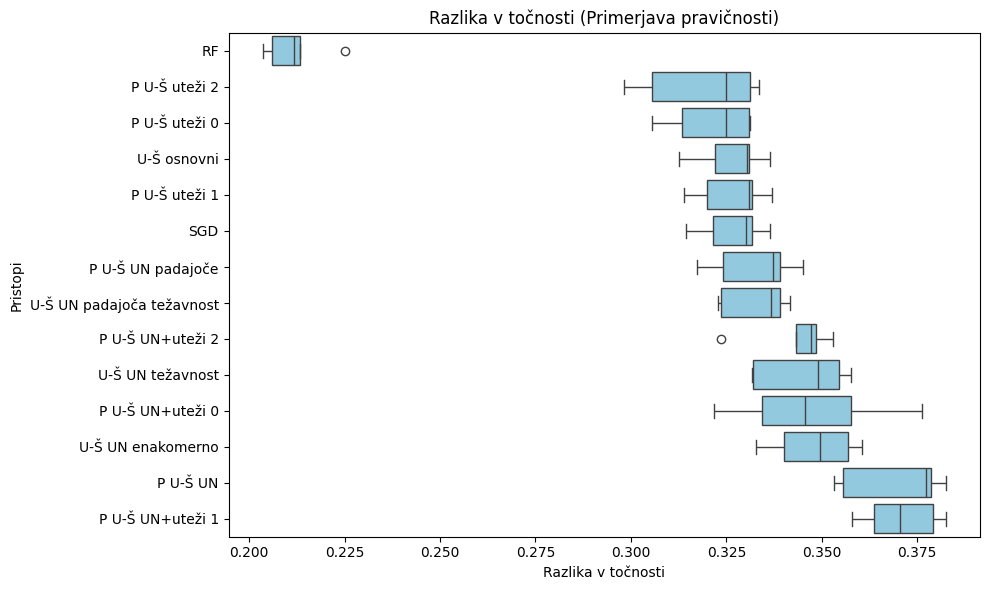

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|RF|0.2252; 0.2060; 0.2036; 0.2118; 0.2133|0.2120|0.2118|0.2036|0.2252|
|P U-Š uteži 2|0.3312; 0.3249; 0.2983; 0.3055; 0.3336|0.3187|0.3249|0.2983|0.3336|
|P U-Š uteži 0|0.3312; 0.3249; 0.3133; 0.3055; 0.3308|0.3211|0.3249|0.3055|0.3312|
|U-Š osnovni|0.3364; 0.3305; 0.3127; 0.3221; 0.3308|0.3265|0.3305|0.3127|0.3364|
|P U-Š uteži 1|0.3370; 0.3316; 0.3139; 0.3199; 0.3308|0.3266|0.3308|0.3139|0.3370|
|SGD|0.3364; 0.3316; 0.3145; 0.3216; 0.3303|0.3269|0.3303|0.3145|0.3364|
|P U-Š UN padajoče|0.3450; 0.3391; 0.3174; 0.3240; 0.3372|0.3326|0.3372|0.3174|0.3450|
|U-Š UN padajoča težavnost|0.3416; 0.3391; 0.3237; 0.3229; 0.3367|0.3328|0.3367|0.3229|0.3416|
|P U-Š UN+uteži 2|0.3433; 0.3528; 0.3473; 0.3235; 0.3485|0.3431|0.3473|0.3235|0.3528|
|U-Š UN težavnost|0.3577; 0.3546; 0.3320; 0.3317; 0.3490|0.3450|0.3490|0.3317|0.3577|
|P U-Š UN+uteži 0|0.3577; 0.3764; 0.3343; 0.3218; 0.3457|0.3472|0.3457|0.3218|0.376

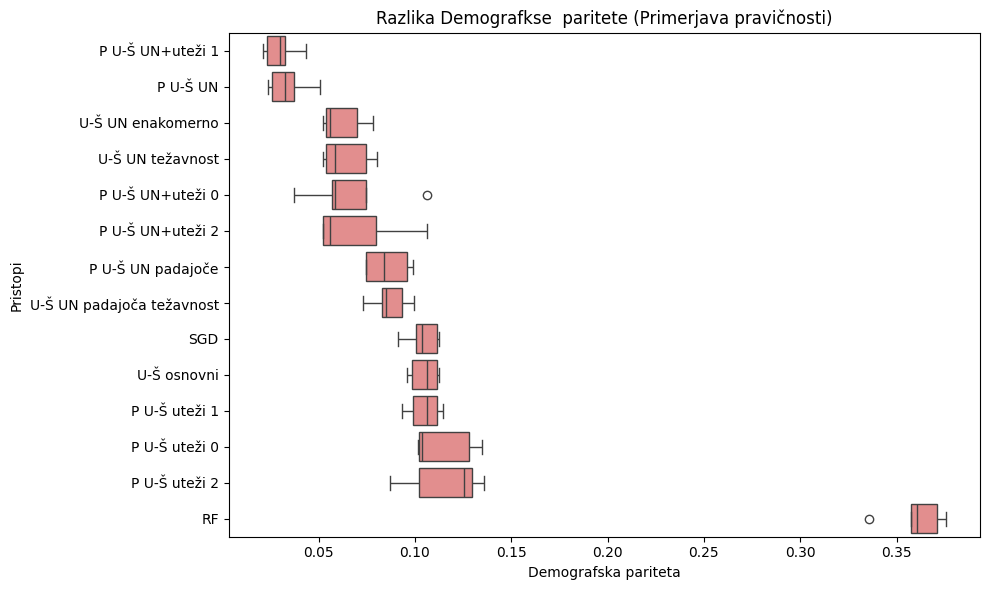

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|P U-Š UN+uteži 1|0.0326; 0.0210; 0.0299; 0.0434; 0.0234|0.0301|0.0299|0.0210|0.0434|
|P U-Š UN|0.0372; 0.0257; 0.0324; 0.0509; 0.0236|0.0340|0.0324|0.0236|0.0509|
|U-Š UN enakomerno|0.0559; 0.0537; 0.0698; 0.0785; 0.0521|0.0620|0.0559|0.0521|0.0785|
|U-Š UN težavnost|0.0588; 0.0539; 0.0748; 0.0802; 0.0521|0.0640|0.0588|0.0521|0.0802|
|P U-Š UN+uteži 0|0.0588; 0.0374; 0.0748; 0.1062; 0.0569|0.0668|0.0588|0.0374|0.1062|
|P U-Š UN+uteži 2|0.0801; 0.0561; 0.0524; 0.1064; 0.0521|0.0694|0.0561|0.0521|0.1064|
|P U-Š UN padajoče|0.0749; 0.0748; 0.0839; 0.0991; 0.0957|0.0857|0.0839|0.0748|0.0991|
|U-Š UN padajoča težavnost|0.0829; 0.0729; 0.0848; 0.0998; 0.0933|0.0867|0.0848|0.0729|0.0998|
|SGD|0.1008; 0.0911; 0.1039; 0.1125; 0.1114|0.1040|0.1039|0.0911|0.1125|
|U-Š osnovni|0.0985; 0.0958; 0.1064; 0.1125; 0.1114|0.1049|0.1064|0.0958|0.1125|
|P U-Š uteži 1|0.0991; 0.0935; 0.1064; 0.1147; 0.1114|0.1050|0.1064

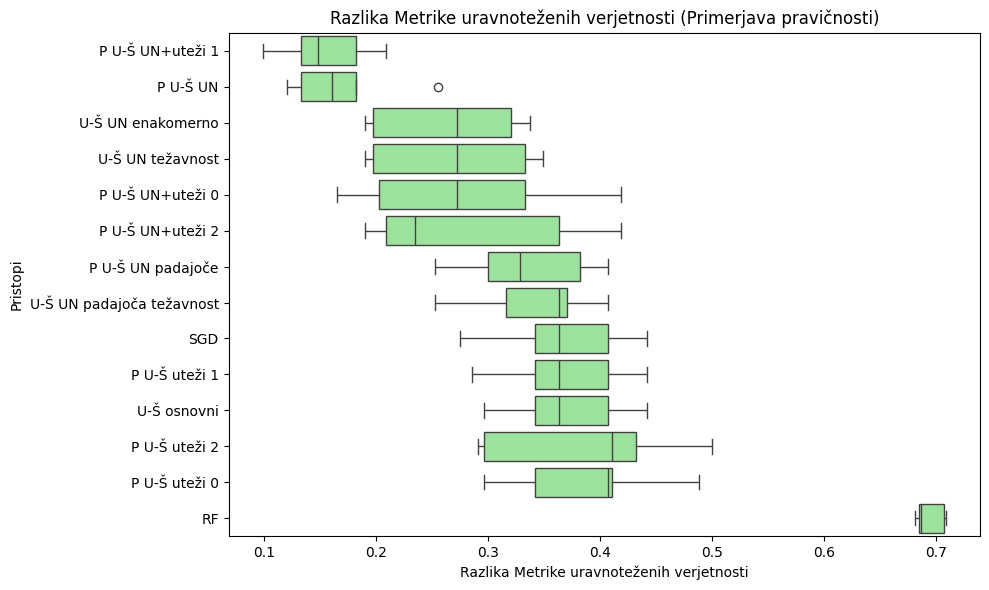

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|P U-Š UN+uteži 1|0.1818; 0.0989; 0.1481; 0.2093; 0.1333|0.1543|0.1481|0.0989|0.2093|
|P U-Š UN|0.1818; 0.1209; 0.1605; 0.2558; 0.1333|0.1705|0.1605|0.1209|0.2558|
|U-Š UN enakomerno|0.2727; 0.1978; 0.3210; 0.3372; 0.1899|0.2637|0.2727|0.1899|0.3372|
|U-Š UN težavnost|0.2727; 0.1978; 0.3333; 0.3488; 0.1899|0.2685|0.2727|0.1899|0.3488|
|P U-Š UN+uteži 0|0.2727; 0.1648; 0.3333; 0.4186; 0.2025|0.2784|0.2727|0.1648|0.4186|
|P U-Š UN+uteži 2|0.3636; 0.2088; 0.2346; 0.4186; 0.1899|0.2831|0.2346|0.1899|0.4186|
|P U-Š UN padajoče|0.3000; 0.2527; 0.3827; 0.4070; 0.3291|0.3343|0.3291|0.2527|0.4070|
|U-Š UN padajoča težavnost|0.3636; 0.2527; 0.3704; 0.4070; 0.3165|0.3420|0.3636|0.2527|0.4070|
|SGD|0.3636; 0.2747; 0.4074; 0.4419; 0.3418|0.3659|0.3636|0.2747|0.4419|
|P U-Š uteži 1|0.3636; 0.2857; 0.4074; 0.4419; 0.3418|0.3681|0.3636|0.2857|0.4419|
|U-Š osnovni|0.3636; 0.2967; 0.4074; 0.4419; 0.3418|0.3703|0.3636

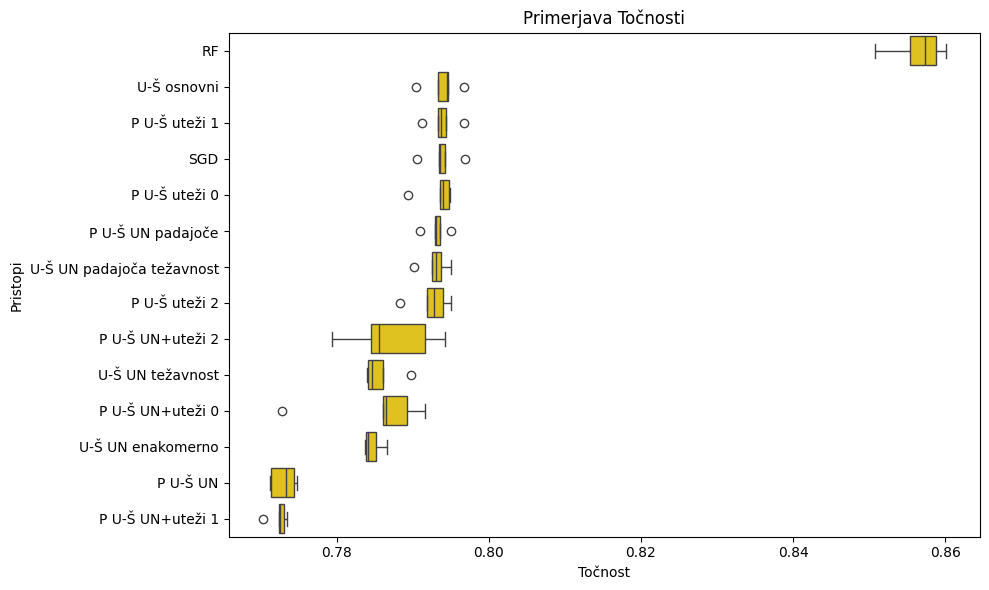

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|RF|0.8554; 0.8601; 0.8587; 0.8573; 0.8507|0.8564|0.8573|0.8507|0.8601|
|U-Š osnovni|0.7968; 0.7945; 0.7946; 0.7904; 0.7933|0.7939|0.7945|0.7904|0.7968|
|P U-Š uteži 1|0.7968; 0.7937; 0.7943; 0.7913; 0.7933|0.7939|0.7937|0.7913|0.7968|
|SGD|0.7969; 0.7935; 0.7942; 0.7905; 0.7935|0.7937|0.7935|0.7905|0.7969|
|P U-Š uteži 0|0.7949; 0.7939; 0.7947; 0.7894; 0.7936|0.7933|0.7939|0.7894|0.7949|
|P U-Š UN padajoče|0.7936; 0.7931; 0.7950; 0.7910; 0.7930|0.7931|0.7931|0.7910|0.7950|
|U-Š UN padajoča težavnost|0.7951; 0.7930; 0.7937; 0.7902; 0.7926|0.7929|0.7930|0.7902|0.7951|
|P U-Š uteži 2|0.7951; 0.7939; 0.7928; 0.7884; 0.7919|0.7924|0.7928|0.7884|0.7951|
|P U-Š UN+uteži 2|0.7942; 0.7855; 0.7794; 0.7917; 0.7845|0.7871|0.7855|0.7794|0.7942|
|U-Š UN težavnost|0.7862; 0.7840; 0.7898; 0.7846; 0.7841|0.7857|0.7846|0.7840|0.7898|
|P U-Š UN+uteži 0|0.7862; 0.7729; 0.7893; 0.7916; 0.7864|0.7853|0.7864|0.7729|0.791

In [88]:
# Instantiate the fairness evaluator
evaluator = FairnessEvaluatorHelper(folds, predictions)

# Compute all fairness metrics
evaluator.compute_fairness_metrics()

# Plot sorted fairness metrics
evaluator.plot_accuracy_differences()
evaluator.plot_demographic_parity()
evaluator.plot_equalized_odds()
evaluator.plot_accuracies()


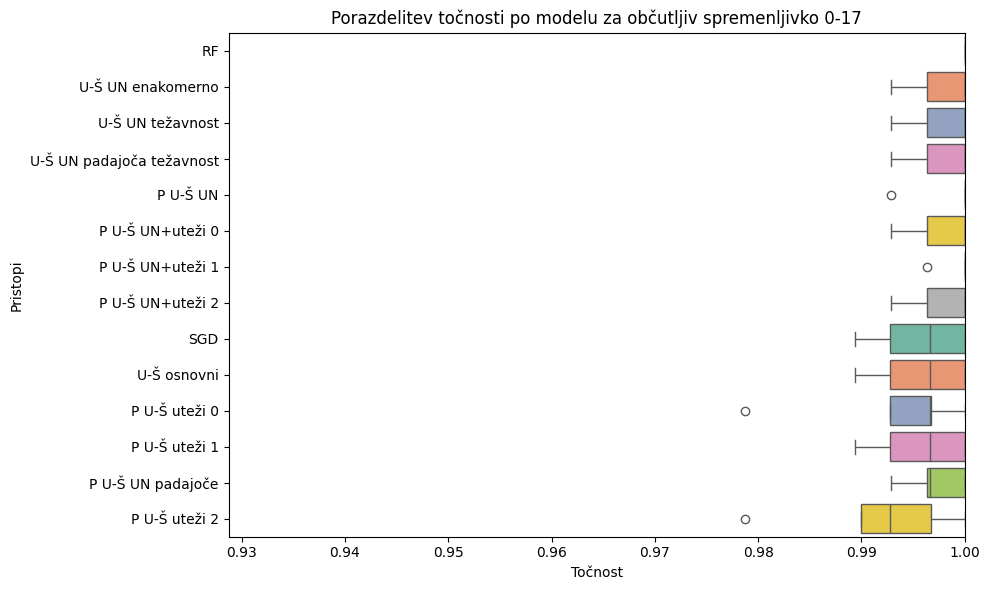

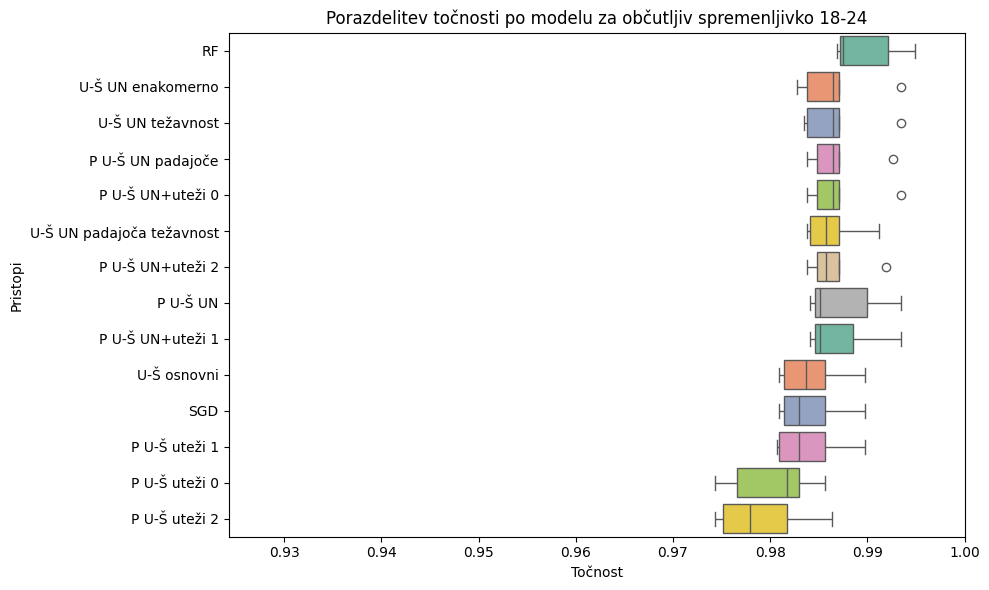

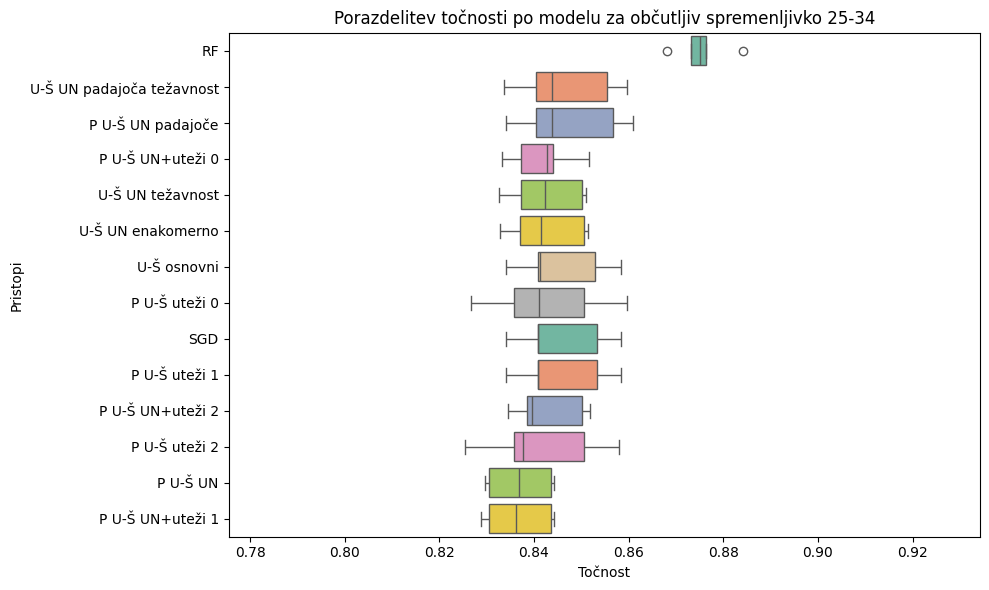

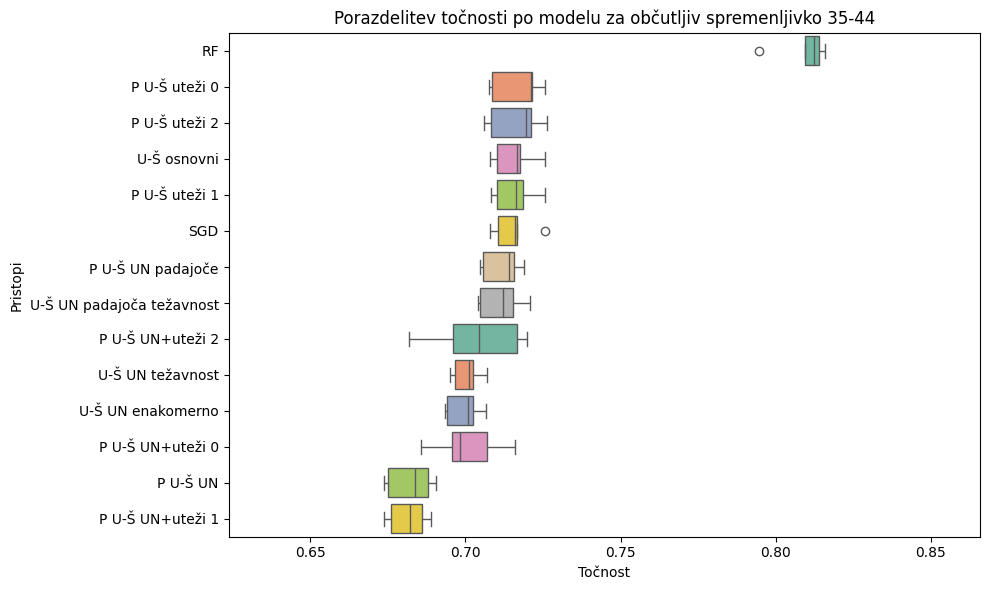

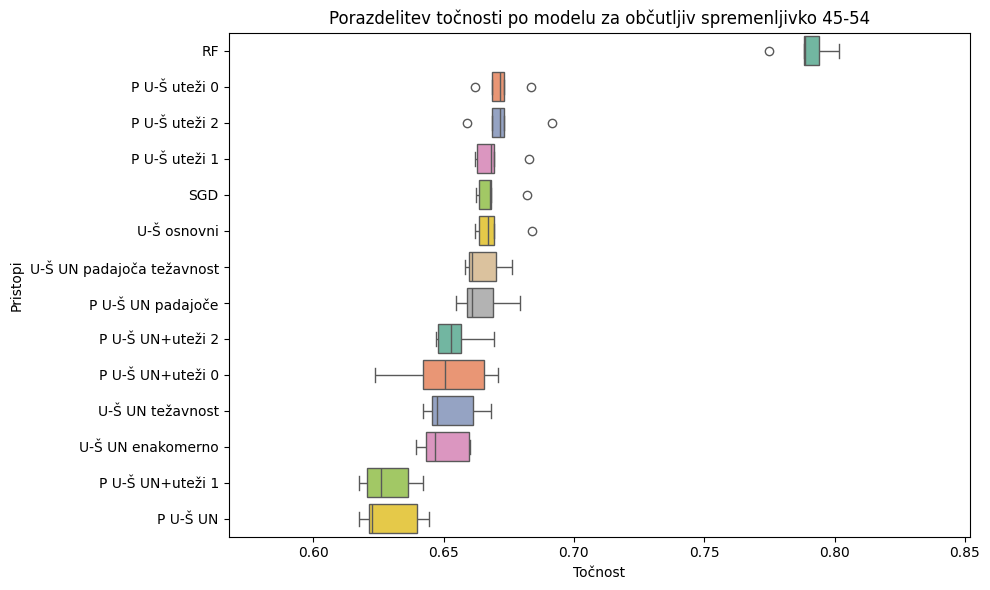

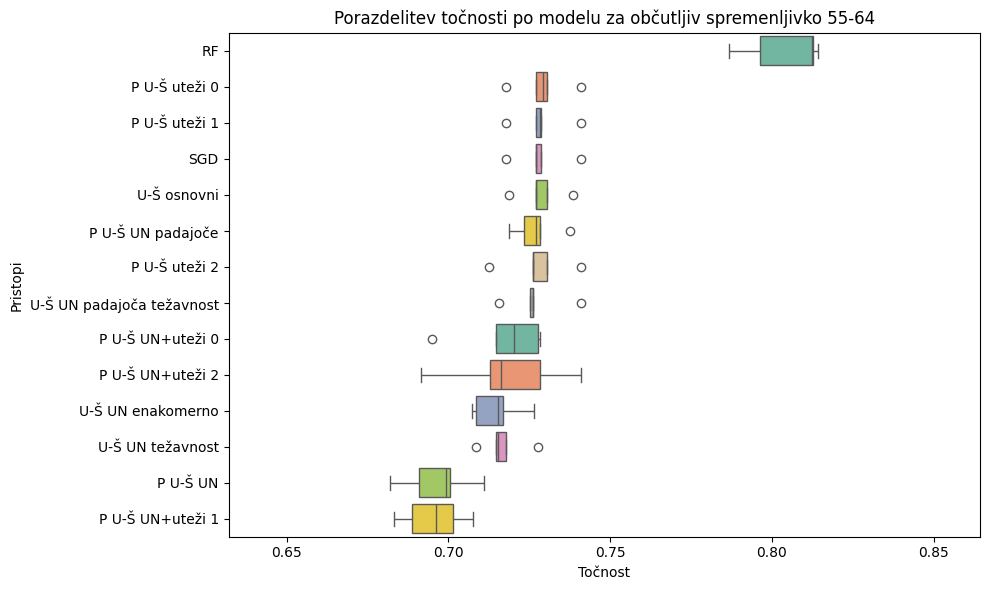

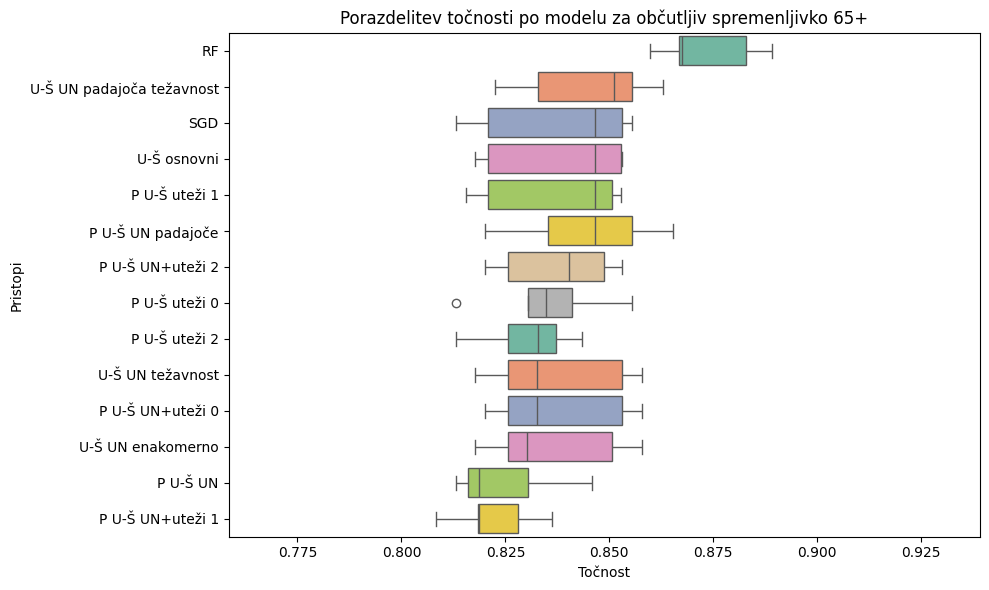

In [89]:
# Plot per-group accuracy distributions
evaluator.plot_group_accuracies(label_encoder=label_encoders['age_class'])

# RACE as a Sensitive feature 

In [90]:
# Load dataset
data = fetch_adult(as_frame=True)
df = data.frame

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("Distribution of 'race' sensitive feature:")
print(df['race'].value_counts())

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['race']  # Sensitive attribute

# Stratified K-Fold Split
# Stratified K-Fold is used instead of regular K-Fold to ensure that each fold maintains 
# the same distribution of the sensetive variable (z). This is crucial when dealing with imbalanced datasets,
# as it prevents some folds from having disproportionately higher or lower occurrences of the target classes.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y, z)): # TODO 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    z_train, z_test = z.iloc[train_idx], z.iloc[test_idx]
    folds.append((X_train, X_test, y_train, y_test, z_train, z_test))

c:\Users\trdin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


In [91]:
predictions = train_and_predict_with_sensitive_feature(folds, sensitive_feature='race')

Training on fold 1...
Min accuracy group: 2
Min accuracy group: 2
Predicting on fold 1...
Fold 1 complete.

Training on fold 2...
Min accuracy group: 2
Min accuracy group: 2
Predicting on fold 2...
Fold 2 complete.

Training on fold 3...
Min accuracy group: 4
Min accuracy group: 4
Predicting on fold 3...
Fold 3 complete.

Training on fold 4...
Min accuracy group: 2
Min accuracy group: 2
Predicting on fold 4...
Fold 4 complete.

Training on fold 5...
Min accuracy group: 4
Min accuracy group: 4
Predicting on fold 5...
Fold 5 complete.



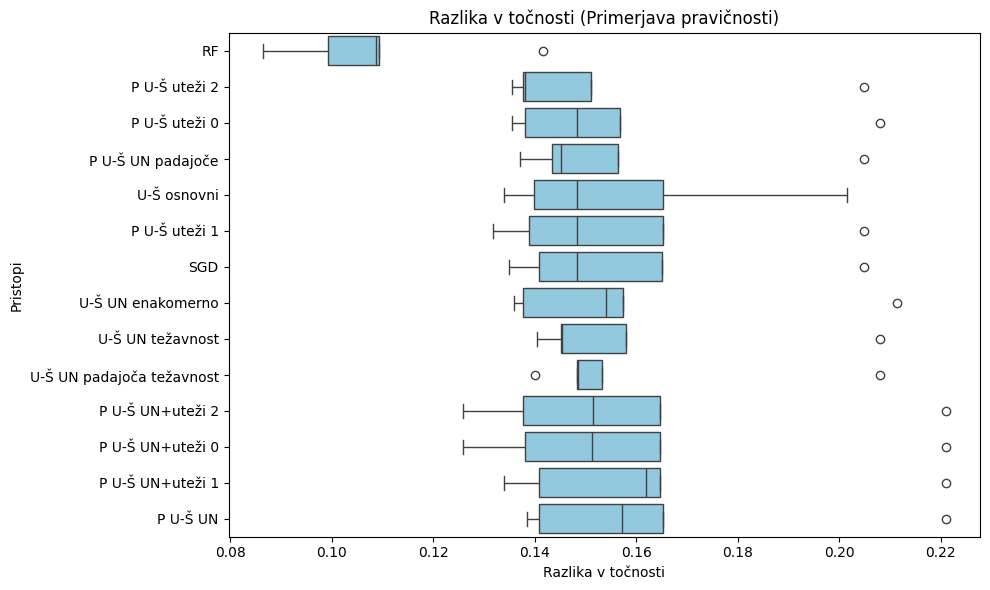

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|RF|0.0864; 0.1416; 0.1094; 0.0993; 0.1087|0.1091|0.1087|0.0864|0.1416|
|P U-Š uteži 2|0.1377; 0.2049; 0.1511; 0.1381; 0.1355|0.1534|0.1381|0.1355|0.2049|
|P U-Š uteži 0|0.1483; 0.2081; 0.1567; 0.1381; 0.1355|0.1573|0.1483|0.1355|0.2081|
|P U-Š UN padajoče|0.1452; 0.2049; 0.1564; 0.1433; 0.1370|0.1574|0.1452|0.1370|0.2049|
|U-Š osnovni|0.1483; 0.2016; 0.1653; 0.1339; 0.1398|0.1578|0.1483|0.1339|0.2016|
|P U-Š uteži 1|0.1483; 0.2049; 0.1653; 0.1318; 0.1389|0.1578|0.1483|0.1318|0.2049|
|SGD|0.1483; 0.2049; 0.1652; 0.1350; 0.1409|0.1588|0.1483|0.1350|0.2049|
|U-Š UN enakomerno|0.1377; 0.2113; 0.1574; 0.1540; 0.1360|0.1593|0.1540|0.1360|0.2113|
|U-Š UN težavnost|0.1452; 0.2081; 0.1581; 0.1455; 0.1405|0.1595|0.1455|0.1405|0.2081|
|U-Š UN padajoča težavnost|0.1483; 0.2081; 0.1532; 0.1487; 0.1402|0.1597|0.1487|0.1402|0.2081|
|P U-Š UN+uteži 2|0.1259; 0.2210; 0.1515; 0.1648; 0.1377|0.1602|0.1515|0.1259|0.22

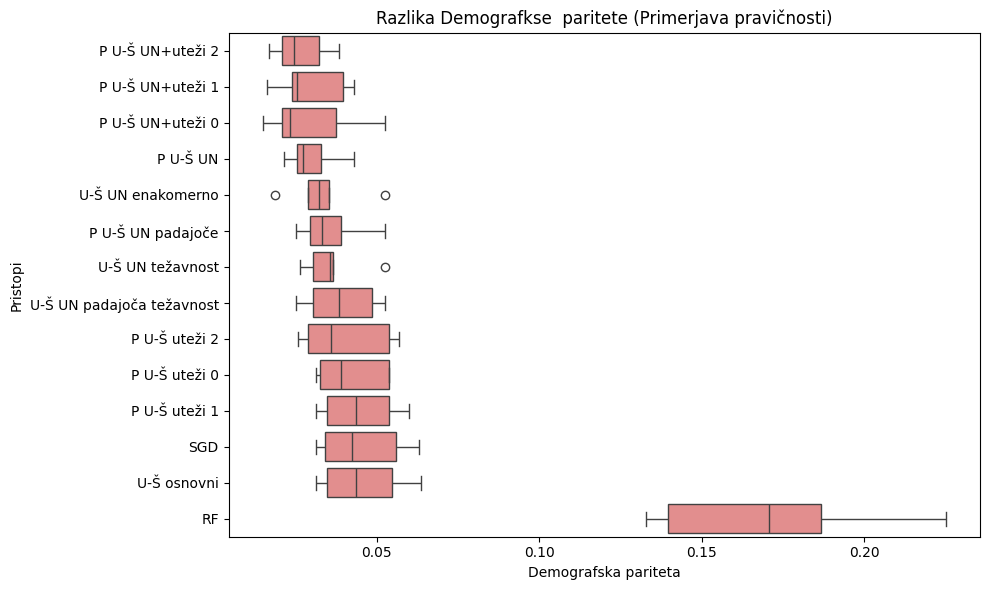

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|P U-Š UN+uteži 2|0.0209; 0.0246; 0.0386; 0.0168; 0.0323|0.0266|0.0246|0.0168|0.0386|
|P U-Š UN+uteži 1|0.0257; 0.0241; 0.0397; 0.0162; 0.0430|0.0297|0.0257|0.0162|0.0430|
|P U-Š UN+uteži 0|0.0209; 0.0235; 0.0375; 0.0150; 0.0528|0.0299|0.0235|0.0150|0.0528|
|P U-Š UN|0.0257; 0.0273; 0.0331; 0.0216; 0.0430|0.0301|0.0273|0.0216|0.0430|
|U-Š UN enakomerno|0.0288; 0.0324; 0.0354; 0.0187; 0.0528|0.0336|0.0324|0.0187|0.0528|
|P U-Š UN padajoče|0.0295; 0.0391; 0.0333; 0.0253; 0.0528|0.0360|0.0333|0.0253|0.0528|
|U-Š UN težavnost|0.0306; 0.0356; 0.0365; 0.0263; 0.0528|0.0363|0.0356|0.0263|0.0528|
|U-Š UN padajoča težavnost|0.0306; 0.0485; 0.0386; 0.0254; 0.0528|0.0392|0.0386|0.0254|0.0528|
|P U-Š uteži 2|0.0288; 0.0569; 0.0361; 0.0258; 0.0538|0.0403|0.0361|0.0258|0.0569|
|P U-Š uteži 0|0.0314; 0.0537; 0.0391; 0.0325; 0.0538|0.0421|0.0391|0.0314|0.0538|
|P U-Š uteži 1|0.0314; 0.0600; 0.0436; 0.0349; 0.0538|0

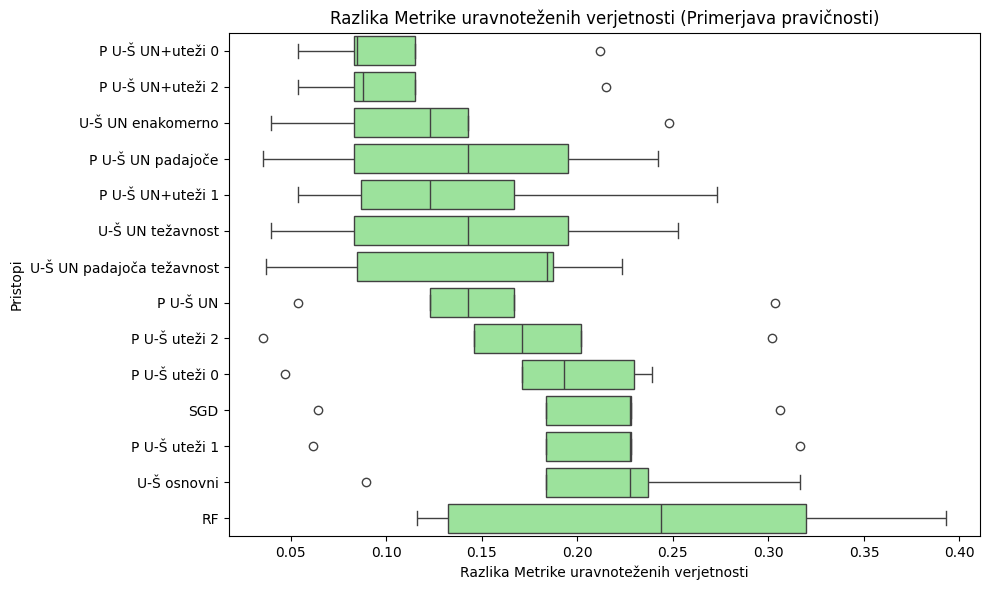

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|P U-Š UN+uteži 0|0.1149; 0.0845; 0.2121; 0.0536; 0.0833|0.1097|0.0845|0.0536|0.2121|
|P U-Š UN+uteži 2|0.1149; 0.0878; 0.2149; 0.0536; 0.0833|0.1109|0.0878|0.0536|0.2149|
|U-Š UN enakomerno|0.1231; 0.1429; 0.2480; 0.0394; 0.0833|0.1273|0.1231|0.0394|0.2480|
|P U-Š UN padajoče|0.1952; 0.1429; 0.2424; 0.0353; 0.0833|0.1398|0.1429|0.0353|0.2424|
|P U-Š UN+uteži 1|0.1231; 0.0869; 0.2730; 0.0536; 0.1667|0.1406|0.1231|0.0536|0.2730|
|U-Š UN težavnost|0.1952; 0.1429; 0.2526; 0.0394; 0.0833|0.1427|0.1429|0.0394|0.2526|
|U-Š UN padajoča težavnost|0.1871; 0.1842; 0.2233; 0.0372; 0.0847|0.1433|0.1842|0.0372|0.2233|
|P U-Š UN|0.1231; 0.1429; 0.3036; 0.0536; 0.1667|0.1579|0.1429|0.0536|0.3036|
|P U-Š uteži 2|0.1462; 0.2018; 0.3021; 0.0353; 0.1708|0.1712|0.1708|0.0353|0.3021|
|P U-Š uteži 0|0.2391; 0.1930; 0.2296; 0.0471; 0.1708|0.1759|0.1930|0.0471|0.2391|
|SGD|0.2276; 0.2281; 0.3061; 0.0644; 0.1833|0.2019|0.22

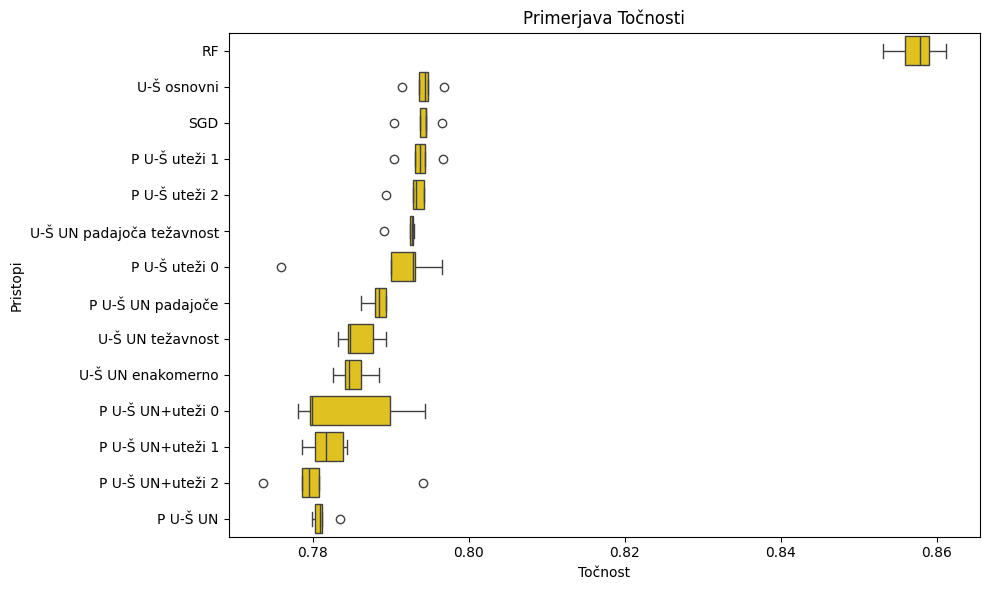

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|RF|0.8560; 0.8612; 0.8590; 0.8579; 0.8532|0.8575|0.8579|0.8532|0.8612|
|U-Š osnovni|0.7968; 0.7948; 0.7943; 0.7915; 0.7936|0.7942|0.7943|0.7915|0.7968|
|SGD|0.7965; 0.7945; 0.7945; 0.7904; 0.7937|0.7939|0.7945|0.7904|0.7965|
|P U-Š uteži 1|0.7967; 0.7937; 0.7943; 0.7903; 0.7931|0.7936|0.7937|0.7903|0.7967|
|P U-Š uteži 2|0.7942; 0.7932; 0.7942; 0.7894; 0.7928|0.7928|0.7932|0.7894|0.7942|
|U-Š UN padajoča težavnost|0.7925; 0.7929; 0.7927; 0.7891; 0.7929|0.7920|0.7927|0.7891|0.7929|
|P U-Š uteži 0|0.7965; 0.7928; 0.7759; 0.7900; 0.7931|0.7897|0.7928|0.7759|0.7965|
|P U-Š UN padajoče|0.7893; 0.7880; 0.7894; 0.7861; 0.7885|0.7883|0.7885|0.7861|0.7894|
|U-Š UN težavnost|0.7893; 0.7832; 0.7877; 0.7847; 0.7845|0.7859|0.7847|0.7832|0.7893|
|U-Š UN enakomerno|0.7862; 0.7826; 0.7885; 0.7846; 0.7841|0.7852|0.7846|0.7826|0.7885|
|P U-Š UN+uteži 0|0.7798; 0.7781; 0.7944; 0.7796; 0.7898|0.7843|0.7798|0.7781|0.79

In [92]:
# Instantiate the fairness evaluator
evaluator = FairnessEvaluatorHelper(folds, predictions)

# Compute all fairness metrics
evaluator.compute_fairness_metrics()

# Plot sorted fairness metrics
evaluator.plot_accuracy_differences()
evaluator.plot_demographic_parity()
evaluator.plot_equalized_odds()
evaluator.plot_accuracies()

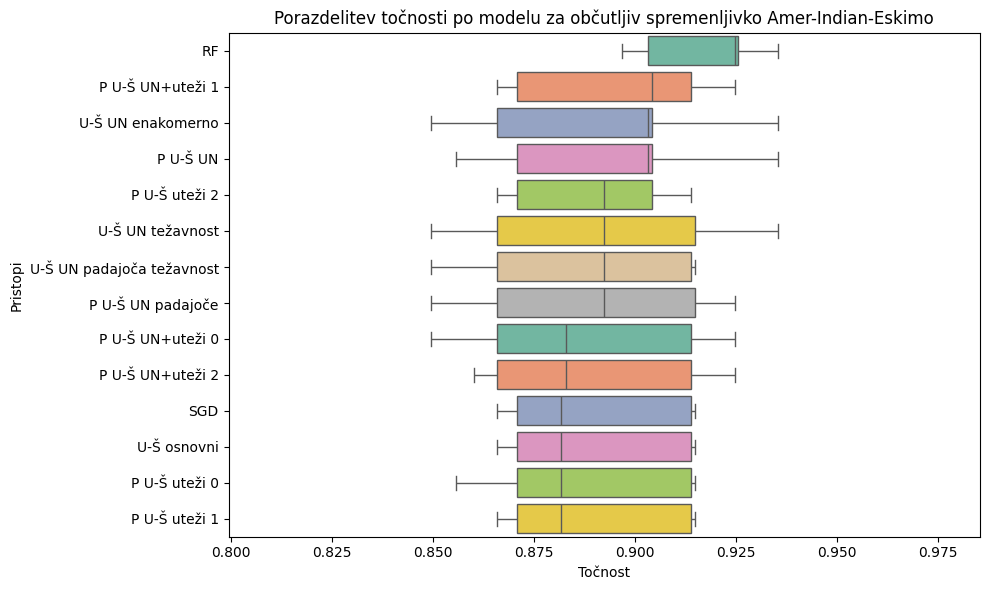

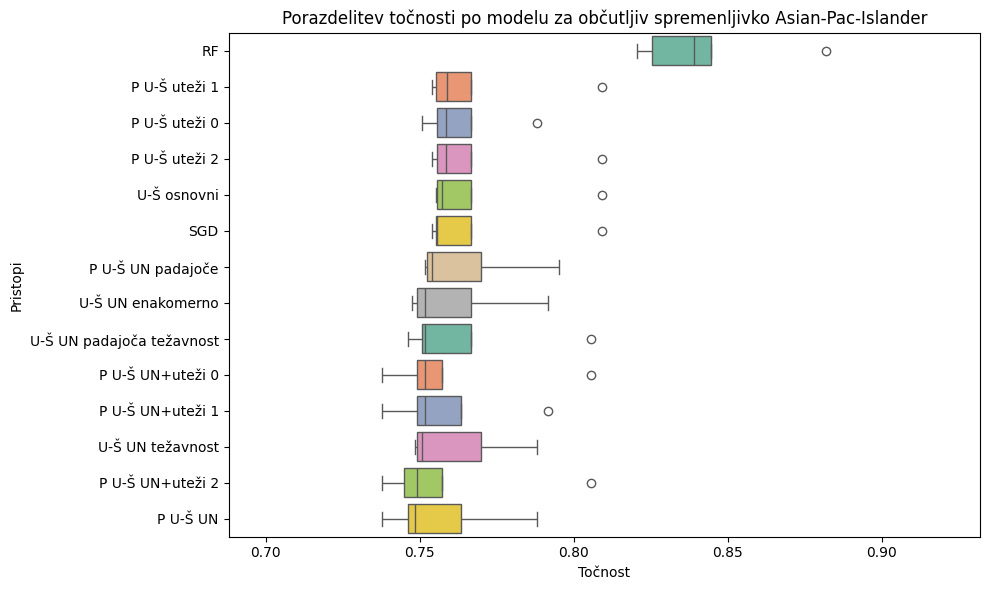

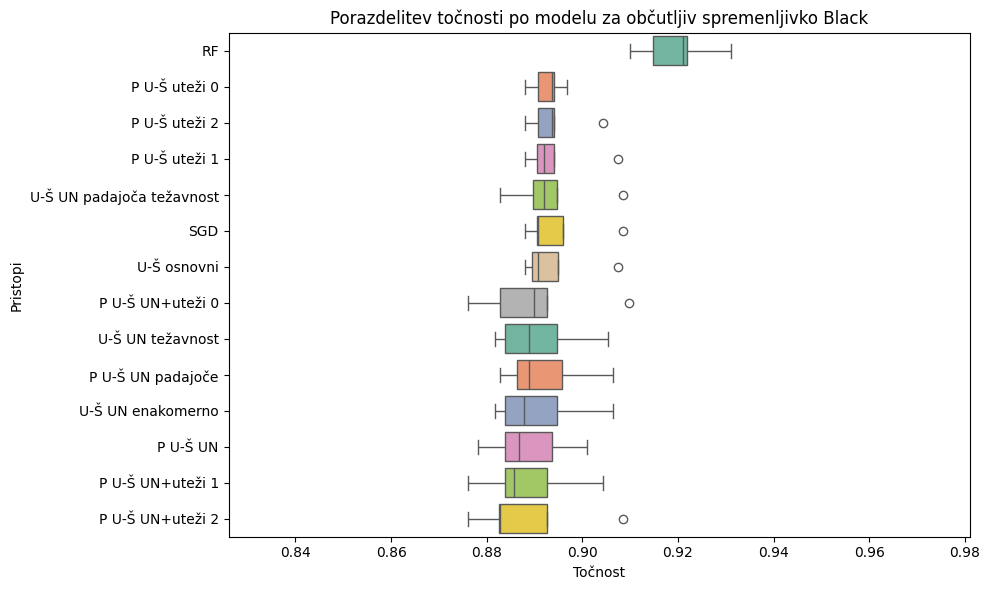

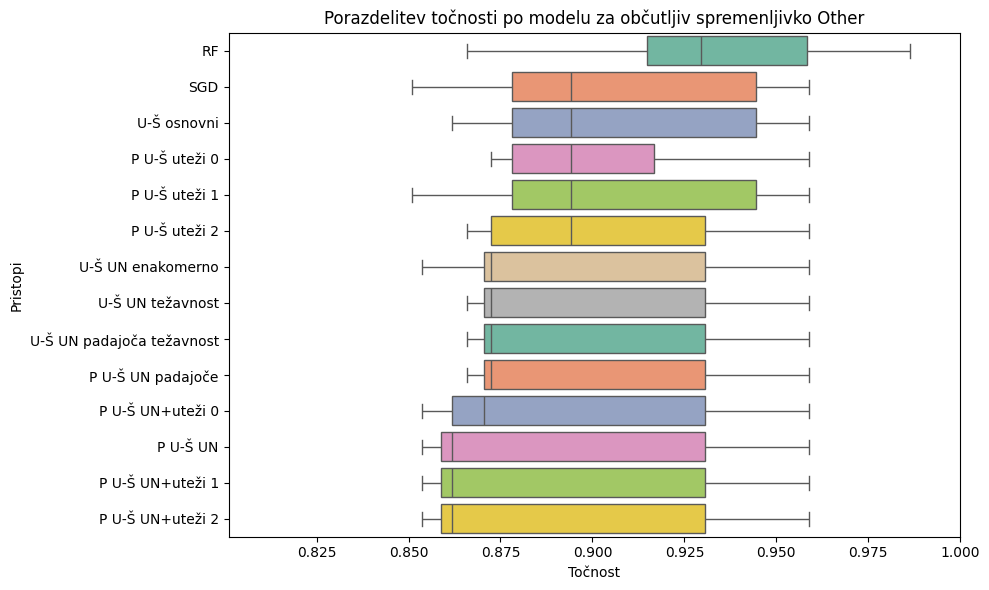

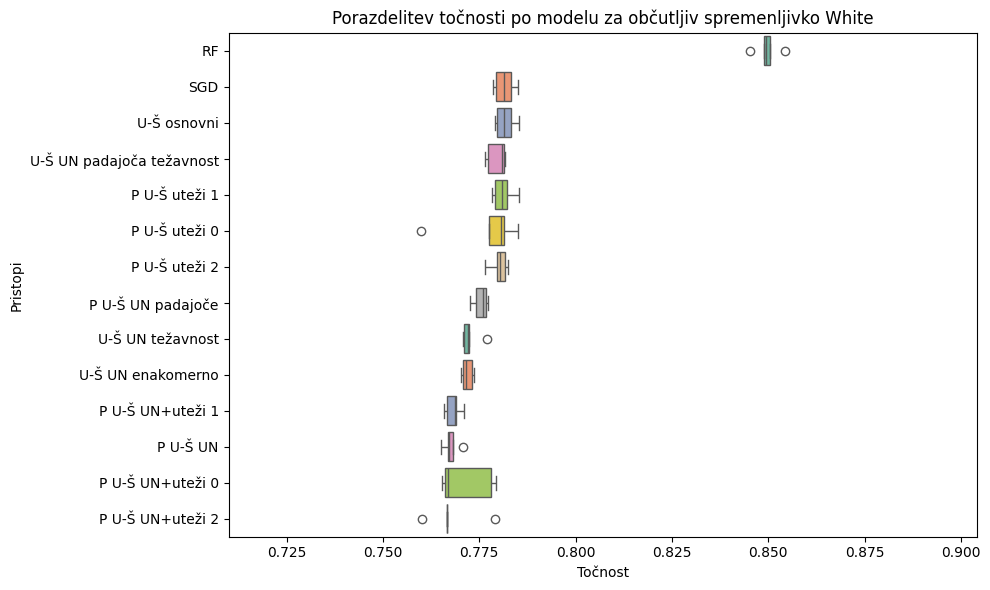

In [93]:
# Plot per-group accuracy distributions
evaluator.plot_group_accuracies(label_encoder=label_encoders['race'])

# Age class and Gender as a Sensitive feature

In [94]:
data = fetch_adult(as_frame=True)
df = data.frame

# Create 'age_class' column
df['age_class'] = pd.cut(df['age'], bins=[0, 18, 24, 34, 44, 54, 64, float('inf')],
                         labels=['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])

# Combine 'gender' (sex) and 'age_class' into a new feature 'gender_age_class'
df['gender_age_class'] = df['sex'].astype(str) + "_" + df['age_class'].astype(str)

# To confirm the sensitive feature, you can check the distribution of the combined sensitive feature
print("Distribution of 'gender_age_class' sensitive feature:")
print(df['gender_age_class'].value_counts())

df.drop(columns=['age_class'], inplace=True)

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'gender_age_class']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le



# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['gender_age_class']  # Combined sensitive attribute (gender + age_class)

# Stratified K-Fold Split (stratified by combined sensitive feature 'gender_age_class')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, z)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    z_train, z_test = z.iloc[train_idx], z.iloc[test_idx]
    folds.append((X_train, X_test, y_train, y_test, z_train, z_test))



Distribution of 'gender_age_class' sensitive feature:
gender_age_class
Male_35-44      8647
Male_25-34      8408
Male_45-54      6214
Female_25-34    4169
Male_18-24      3878
Female_35-44    3546
Male_55-64      3373
Female_18-24    3097
Female_45-54    2557
Female_55-64    1409
Male_65+        1395
Male_0-17        735
Female_0-17      722
Female_65+       692
Name: count, dtype: int64


In [95]:
predictions = train_and_predict_with_sensitive_feature(folds, sensitive_feature='gender_age_class')

Training on fold 1...
Min accuracy group: 1
Min accuracy group: 2
Predicting on fold 1...
Fold 1 complete.

Training on fold 2...
Min accuracy group: 3
Min accuracy group: 11
Predicting on fold 2...
Fold 2 complete.

Training on fold 3...
Min accuracy group: 10
Min accuracy group: 10
Predicting on fold 3...
Fold 3 complete.

Training on fold 4...
Min accuracy group: 11
Min accuracy group: 11
Predicting on fold 4...
Fold 4 complete.

Training on fold 5...
Min accuracy group: 2
Min accuracy group: 11
Predicting on fold 5...
Fold 5 complete.



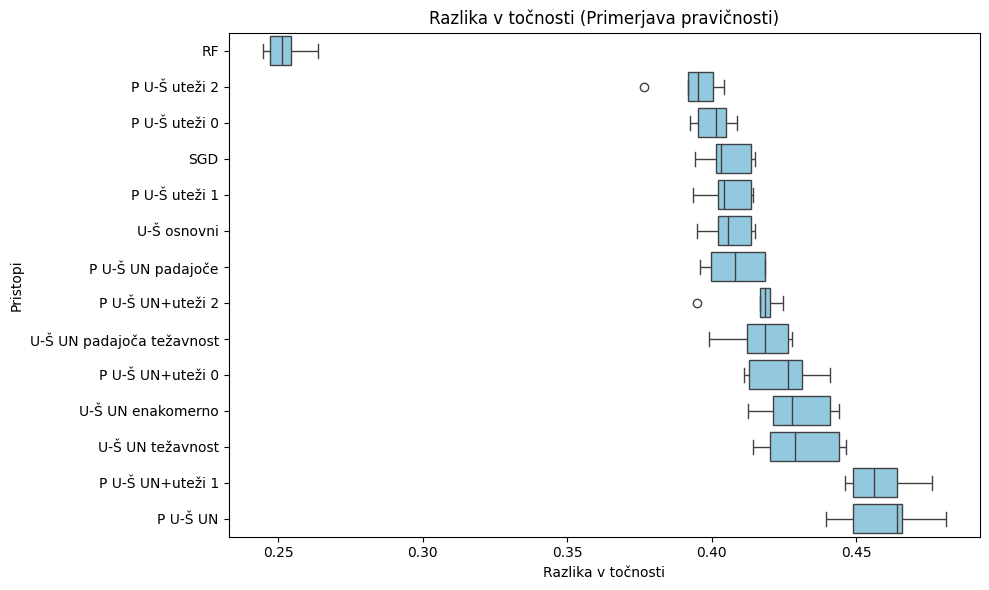

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|RF|0.2512; 0.2542; 0.2446; 0.2470; 0.2637|0.2521|0.2512|0.2446|0.2637|
|P U-Š uteži 2|0.4042; 0.3918; 0.4006; 0.3766; 0.3953|0.3937|0.3953|0.3766|0.4042|
|P U-Š uteži 0|0.4050; 0.3926; 0.4014; 0.3954; 0.4087|0.4006|0.4014|0.3926|0.4087|
|SGD|0.4034; 0.3942; 0.4014; 0.4135; 0.4151|0.4055|0.4034|0.3942|0.4151|
|P U-Š uteži 1|0.4042; 0.3934; 0.4023; 0.4135; 0.4143|0.4055|0.4042|0.3934|0.4143|
|U-Š osnovni|0.4058; 0.3950; 0.4023; 0.4135; 0.4151|0.4063|0.4058|0.3950|0.4151|
|P U-Š UN padajoče|0.4082; 0.3958; 0.3998; 0.4183; 0.4183|0.4081|0.4082|0.3958|0.4183|
|P U-Š UN+uteži 2|0.4203; 0.3950; 0.4167; 0.4183; 0.4248|0.4150|0.4183|0.3950|0.4248|
|U-Š UN padajoča težavnost|0.4122; 0.3990; 0.4183; 0.4280; 0.4264|0.4168|0.4183|0.3990|0.4280|
|P U-Š UN+uteži 0|0.4130; 0.4111; 0.4312; 0.4409; 0.4264|0.4245|0.4264|0.4111|0.4409|
|U-Š UN enakomerno|0.4211; 0.4127; 0.4280; 0.4409; 0.4441|0.4294|0.4280|0.4127|0.44

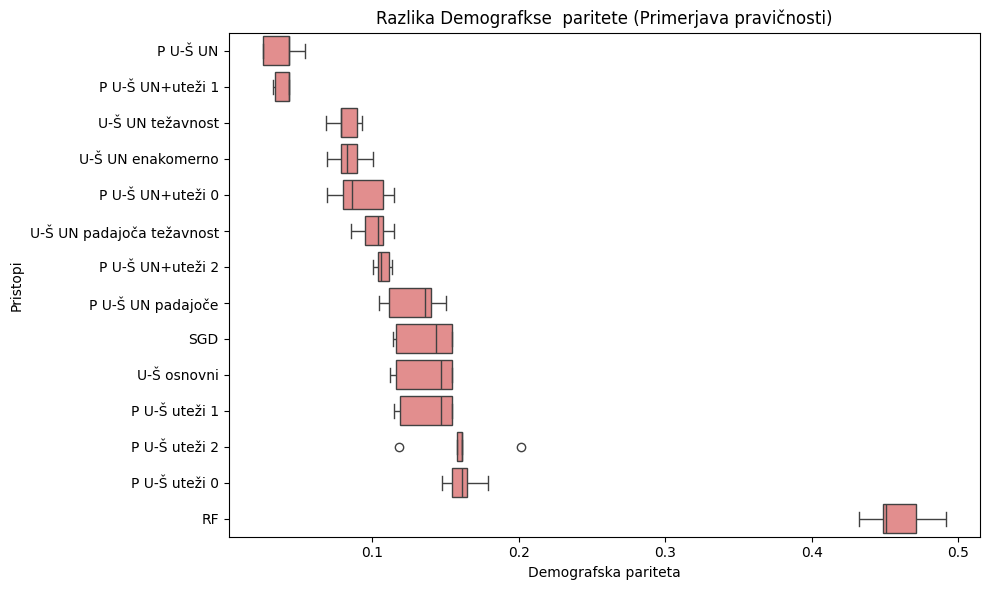

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|P U-Š UN|0.0538; 0.0430; 0.0251; 0.0251; 0.0430|0.0380|0.0430|0.0251|0.0538|
|P U-Š UN+uteži 1|0.0430; 0.0430; 0.0430; 0.0323; 0.0338|0.0390|0.0430|0.0323|0.0430|
|U-Š UN težavnost|0.0932; 0.0789; 0.0896; 0.0681; 0.0789|0.0817|0.0789|0.0681|0.0932|
|U-Š UN enakomerno|0.1004; 0.0789; 0.0896; 0.0692; 0.0824|0.0841|0.0824|0.0692|0.1004|
|P U-Š UN+uteži 0|0.1147; 0.0796; 0.0860; 0.0692; 0.1075|0.0914|0.0860|0.0692|0.1147|
|U-Š UN padajoča težavnost|0.1147; 0.0949; 0.1039; 0.0853; 0.1075|0.1013|0.1039|0.0853|0.1147|
|P U-Š UN+uteži 2|0.1004; 0.1134; 0.1039; 0.1062; 0.1111|0.1070|0.1062|0.1004|0.1134|
|P U-Š UN padajoče|0.1505; 0.1046; 0.1362; 0.1111; 0.1398|0.1284|0.1362|0.1046|0.1505|
|SGD|0.1541; 0.1142; 0.1434; 0.1158; 0.1541|0.1363|0.1434|0.1142|0.1541|
|U-Š osnovni|0.1541; 0.1118; 0.1470; 0.1158; 0.1541|0.1366|0.1470|0.1118|0.1541|
|P U-Š uteži 1|0.1541; 0.1150; 0.1470; 0.1191; 0.1541|0.1379|0.1470

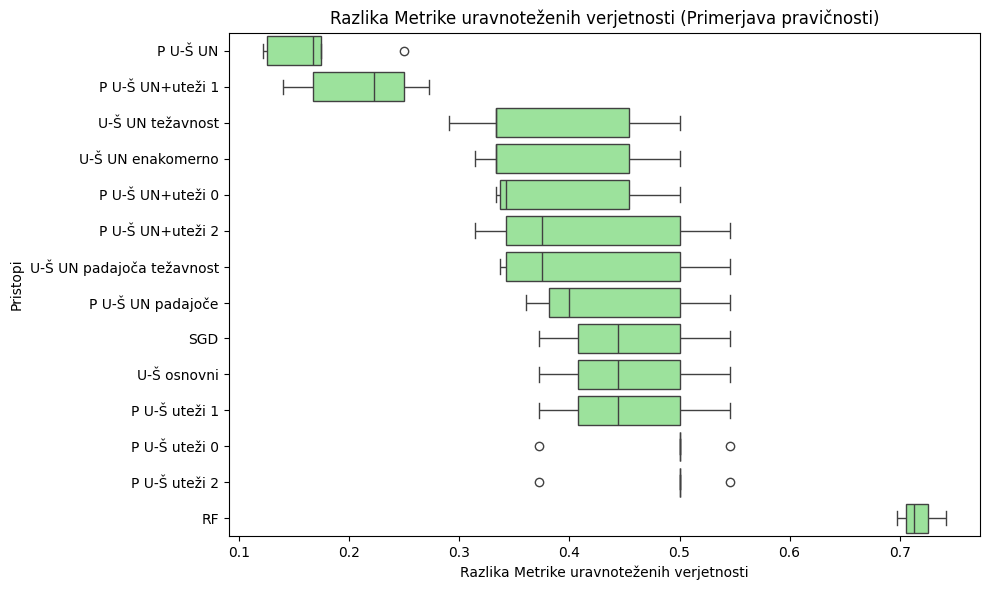

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|P U-Š UN|0.1744; 0.2500; 0.1212; 0.1250; 0.1667|0.1675|0.1667|0.1212|0.2500|
|P U-Š UN+uteži 1|0.1395; 0.2500; 0.2727; 0.2222; 0.1667|0.2102|0.2222|0.1395|0.2727|
|U-Š UN težavnost|0.2907; 0.5000; 0.4545; 0.3333; 0.3333|0.3824|0.3333|0.2907|0.5000|
|U-Š UN enakomerno|0.3140; 0.5000; 0.4545; 0.3333; 0.3333|0.3870|0.3333|0.3140|0.5000|
|P U-Š UN+uteži 0|0.3372; 0.5000; 0.4545; 0.3333; 0.3421|0.3934|0.3421|0.3333|0.5000|
|P U-Š UN+uteži 2|0.3140; 0.5000; 0.5455; 0.3750; 0.3421|0.4153|0.3750|0.3140|0.5455|
|U-Š UN padajoča težavnost|0.3372; 0.5000; 0.5455; 0.3750; 0.3421|0.4200|0.3750|0.3372|0.5455|
|P U-Š UN padajoče|0.3605; 0.5000; 0.5455; 0.4000; 0.3816|0.4375|0.4000|0.3605|0.5455|
|SGD|0.3721; 0.5000; 0.5455; 0.4444; 0.4079|0.4540|0.4444|0.3721|0.5455|
|U-Š osnovni|0.3721; 0.5000; 0.5455; 0.4444; 0.4079|0.4540|0.4444|0.3721|0.5455|
|P U-Š uteži 1|0.3721; 0.5000; 0.5455; 0.4444; 0.4079|0.4540|0.4444

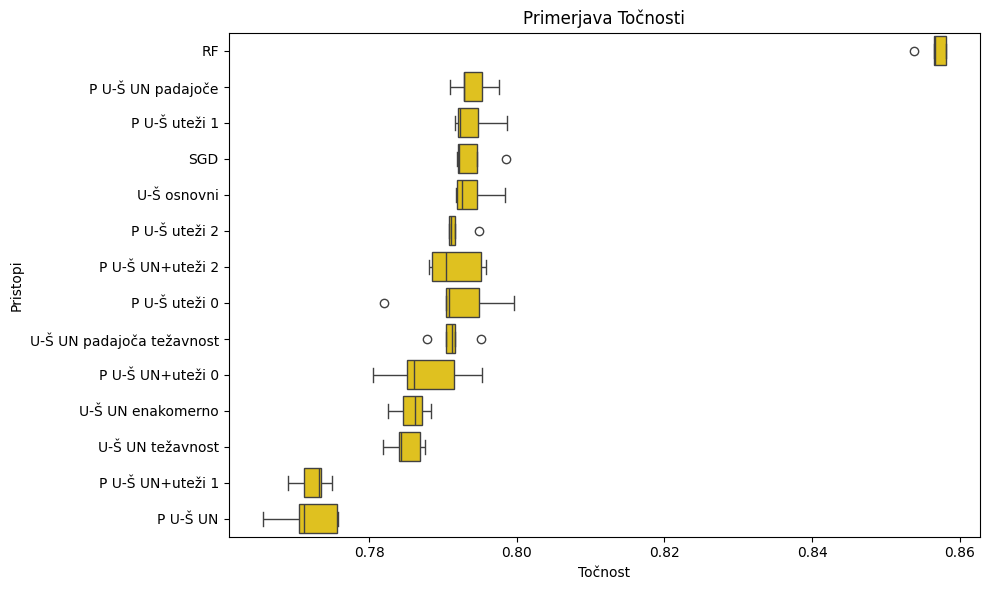

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|RF|0.8581; 0.8538; 0.8567; 0.8566; 0.8581|0.8567|0.8567|0.8538|0.8581|
|P U-Š UN padajoče|0.7910; 0.7928; 0.7928; 0.7952; 0.7976|0.7939|0.7928|0.7910|0.7976|
|P U-Š uteži 1|0.7920; 0.7916; 0.7923; 0.7947; 0.7987|0.7939|0.7923|0.7916|0.7987|
|SGD|0.7921; 0.7919; 0.7921; 0.7946; 0.7985|0.7938|0.7921|0.7919|0.7985|
|U-Š osnovni|0.7917; 0.7919; 0.7926; 0.7945; 0.7984|0.7938|0.7926|0.7917|0.7984|
|P U-Š uteži 2|0.7908; 0.7909; 0.7911; 0.7916; 0.7948|0.7918|0.7911|0.7908|0.7948|
|P U-Š UN+uteži 2|0.7881; 0.7905; 0.7885; 0.7951; 0.7958|0.7916|0.7905|0.7881|0.7958|
|P U-Š uteži 0|0.7908; 0.7821; 0.7903; 0.7948; 0.7997|0.7915|0.7908|0.7821|0.7997|
|U-Š UN padajoča težavnost|0.7916; 0.7912; 0.7878; 0.7903; 0.7951|0.7912|0.7912|0.7878|0.7951|
|P U-Š UN+uteži 0|0.7915; 0.7851; 0.7805; 0.7860; 0.7952|0.7877|0.7860|0.7805|0.7952|
|U-Š UN enakomerno|0.7883; 0.7845; 0.7826; 0.7861; 0.7872|0.7857|0.7861|0.7826|0.78

In [96]:
# Instantiate the fairness evaluator
evaluator = FairnessEvaluatorHelper(folds, predictions)

# Compute all fairness metrics
evaluator.compute_fairness_metrics()

# Plot sorted fairness metrics
evaluator.plot_accuracy_differences()
evaluator.plot_demographic_parity()
evaluator.plot_equalized_odds()
evaluator.plot_accuracies()

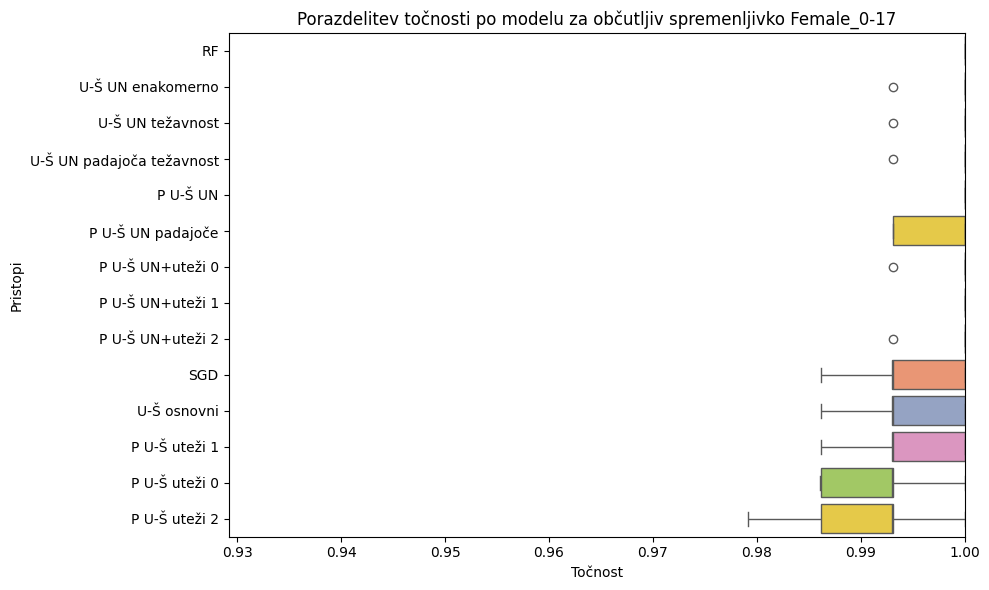

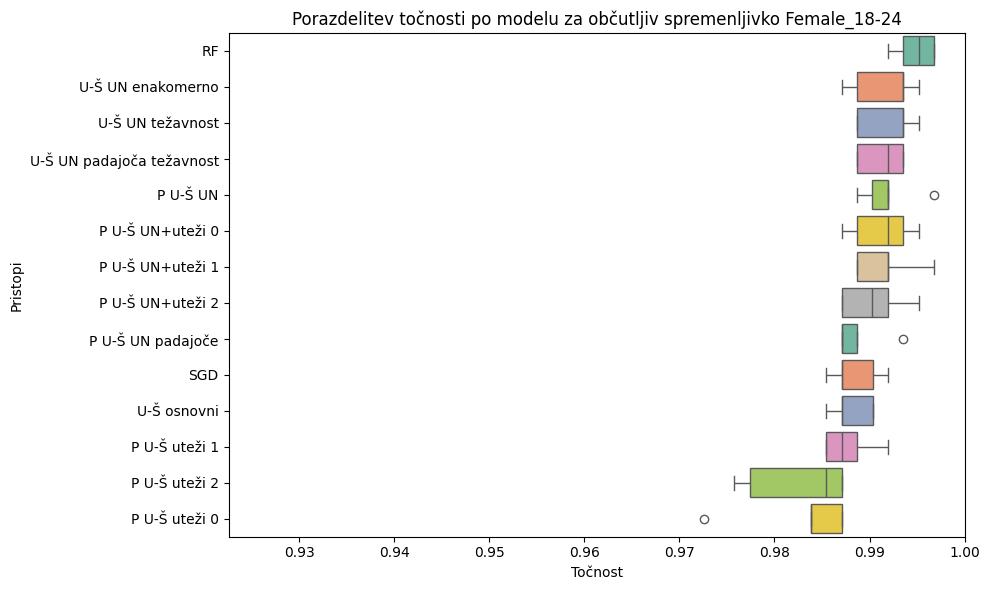

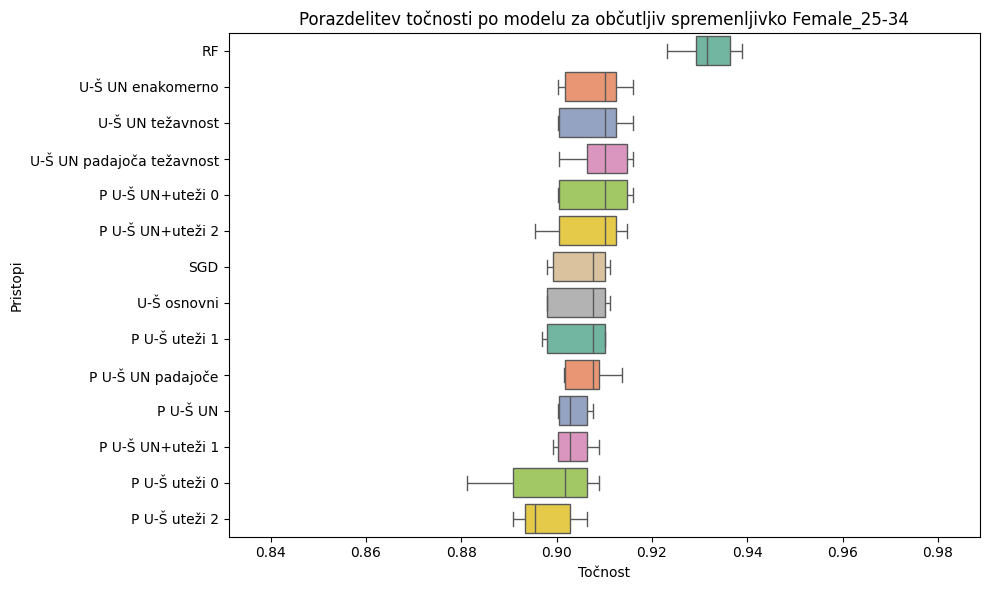

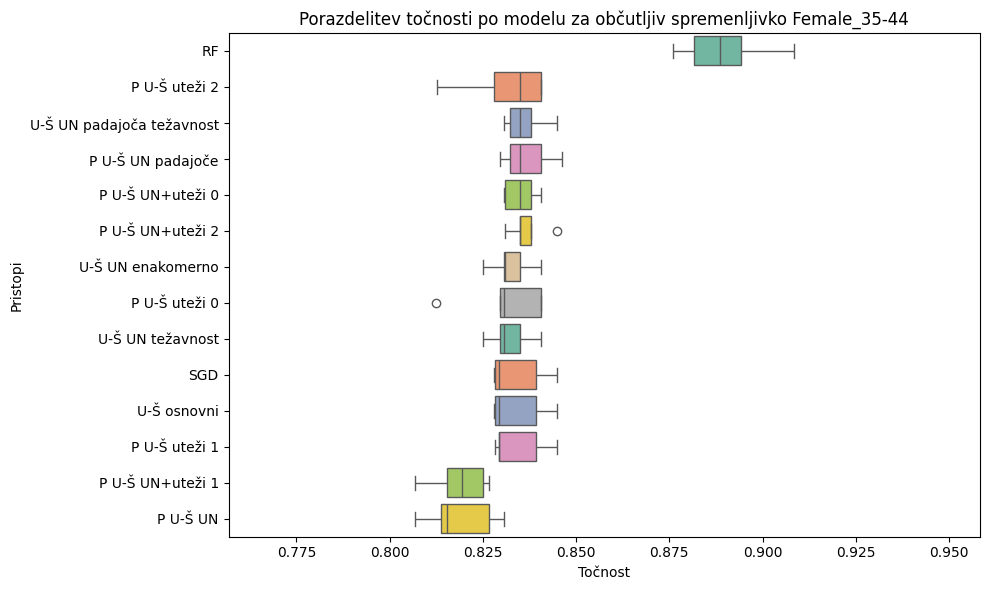

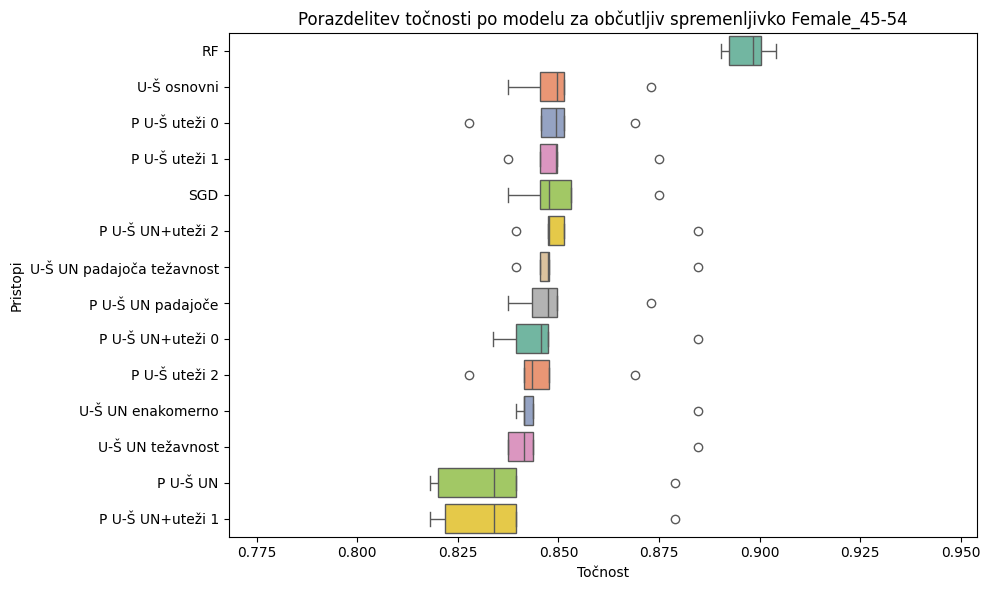

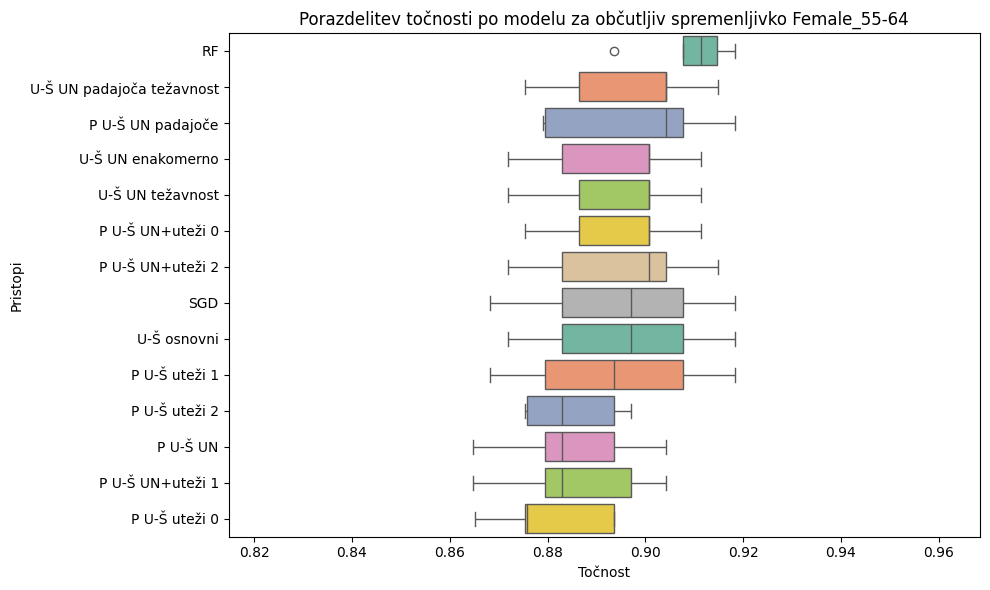

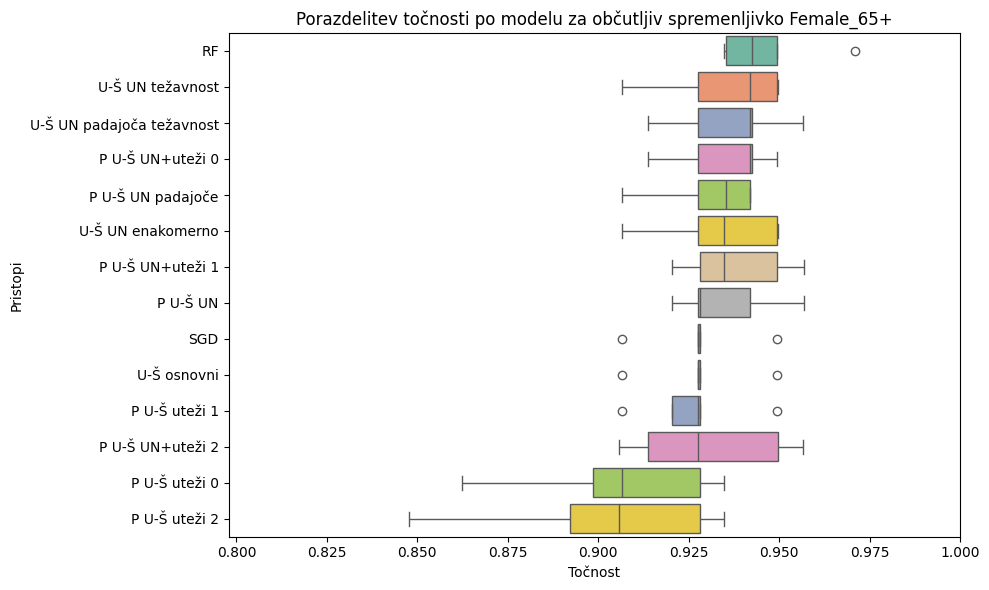

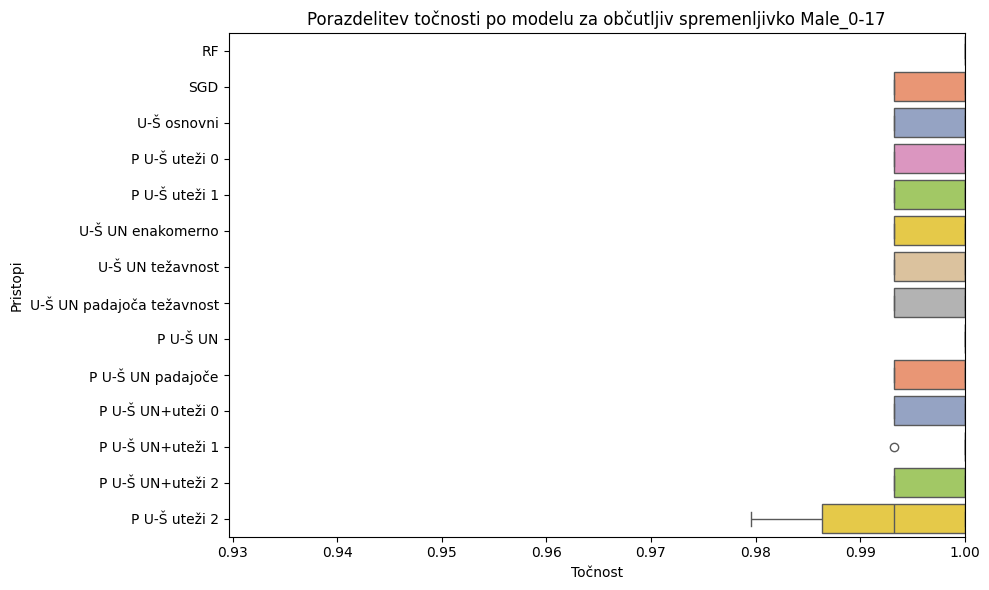

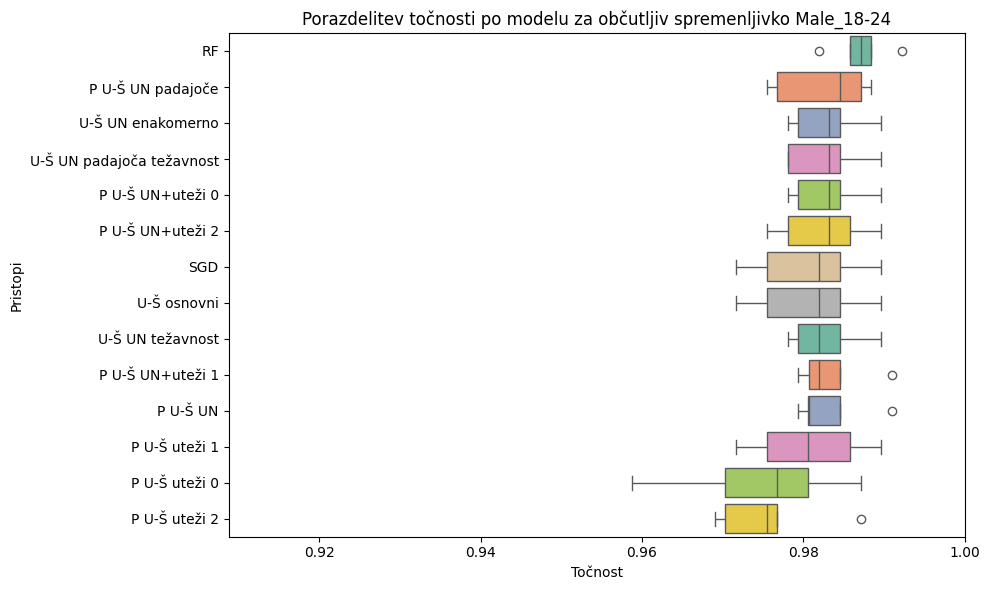

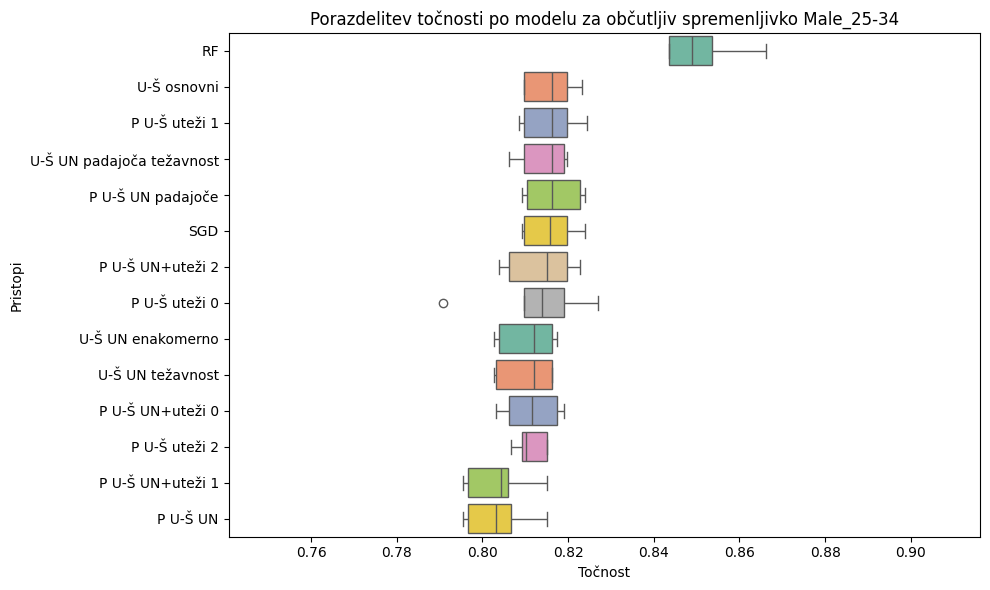

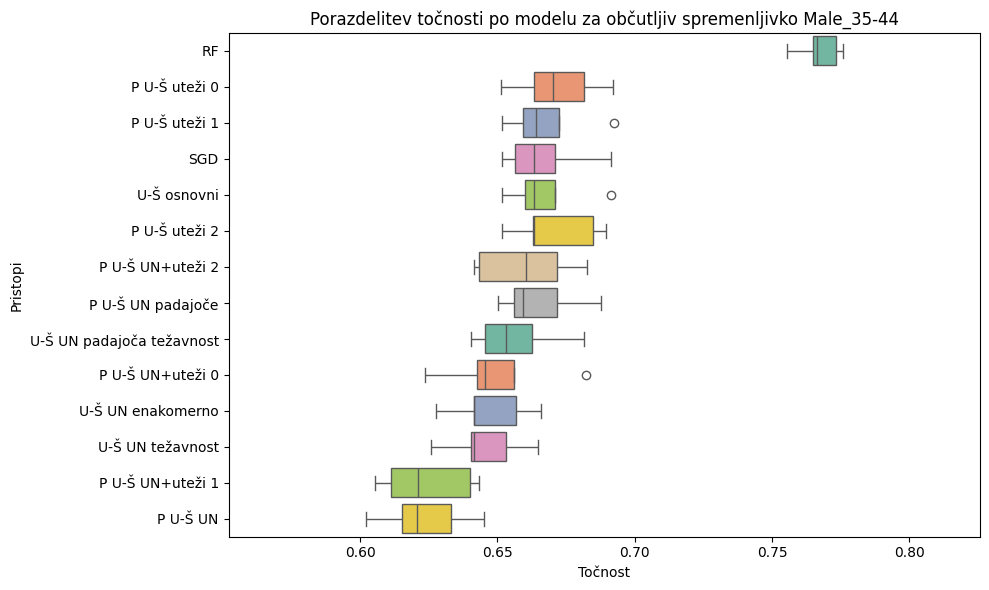

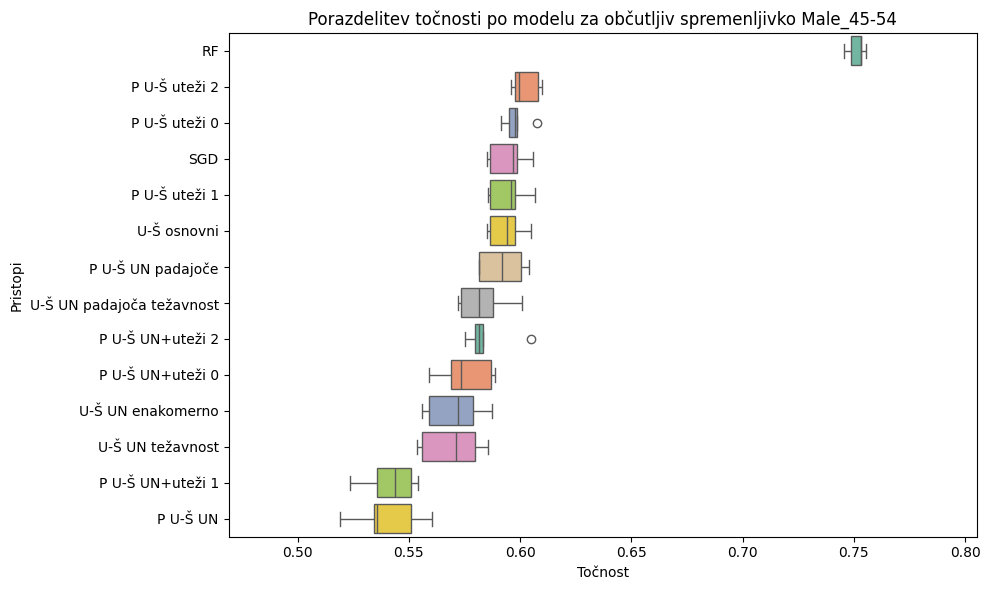

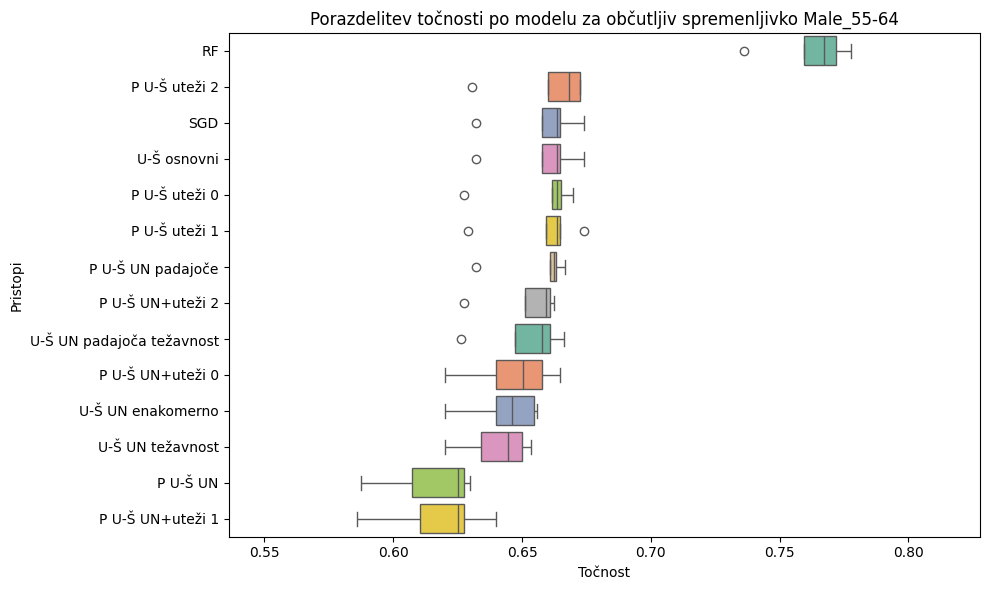

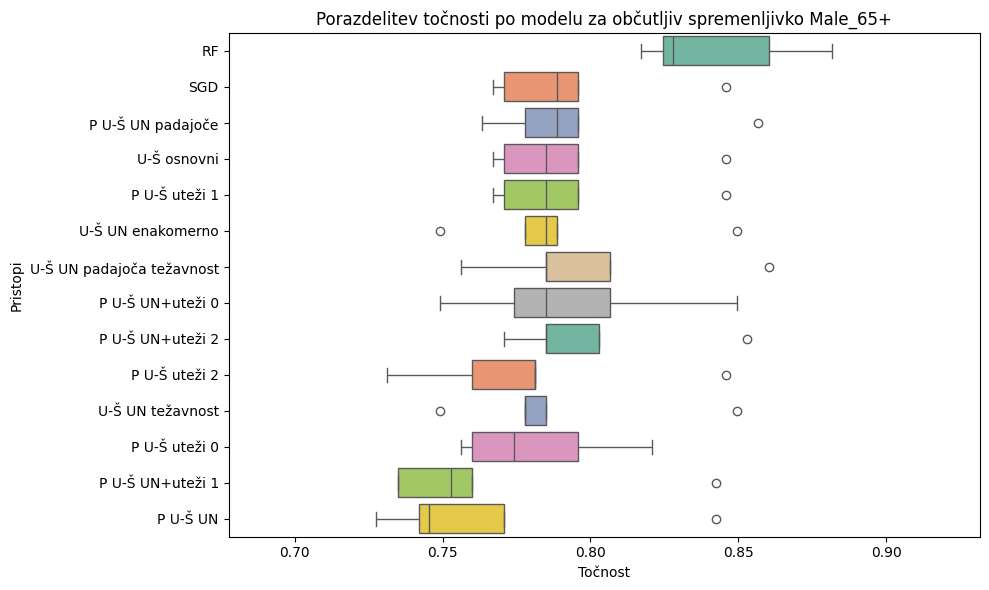

In [97]:
# Plot per-group accuracy distributions
evaluator.plot_group_accuracies(label_encoder=label_encoders['gender_age_class'])

# Race and Gender as a Sensitive feature

In [7]:
data = fetch_adult(as_frame=True)
df = data.frame



df['gender_race'] = df['sex'].astype(str) + "_" + df['race'].astype(str)

# To confirm the sensitive feature, you can check the distribution of the combined sensitive feature
print("Distribution of 'gender_age_class' sensitive feature:")
print(df['gender_race'].value_counts())


# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'gender_race']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le



# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['gender_race']  # Combined sensitive attribute (gender + age_class)

# Stratified K-Fold Split (stratified by combined sensitive feature 'gender_age_class')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X,y, z)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    z_train, z_test = z.iloc[train_idx], z.iloc[test_idx]
    folds.append((X_train, X_test, y_train, y_test, z_train, z_test))


Distribution of 'gender_age_class' sensitive feature:
gender_race
Male_White                   28735
Female_White                 13027
Male_Black                    2377
Female_Black                  2308
Male_Asian-Pac-Islander       1002
Female_Asian-Pac-Islander      517
Male_Amer-Indian-Eskimo        285
Male_Other                     251
Female_Amer-Indian-Eskimo      185
Female_Other                   155
Name: count, dtype: int64


c:\Users\trdin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


In [8]:
predictions = train_and_predict_with_sensitive_feature(folds, sensitive_feature='gender_race')

Training on fold 1...
Min accuracy group: 7
Min accuracy group: 7
Predicting on fold 1...
Fold 1 complete.

Training on fold 2...
Min accuracy group: 7
Min accuracy group: 7
Predicting on fold 2...
Fold 2 complete.

Training on fold 3...
Min accuracy group: 9
Min accuracy group: 9
Predicting on fold 3...
Fold 3 complete.

Training on fold 4...
Min accuracy group: 7
Min accuracy group: 7
Predicting on fold 4...
Fold 4 complete.

Training on fold 5...
Min accuracy group: 4
Min accuracy group: 4
Predicting on fold 5...
Fold 5 complete.



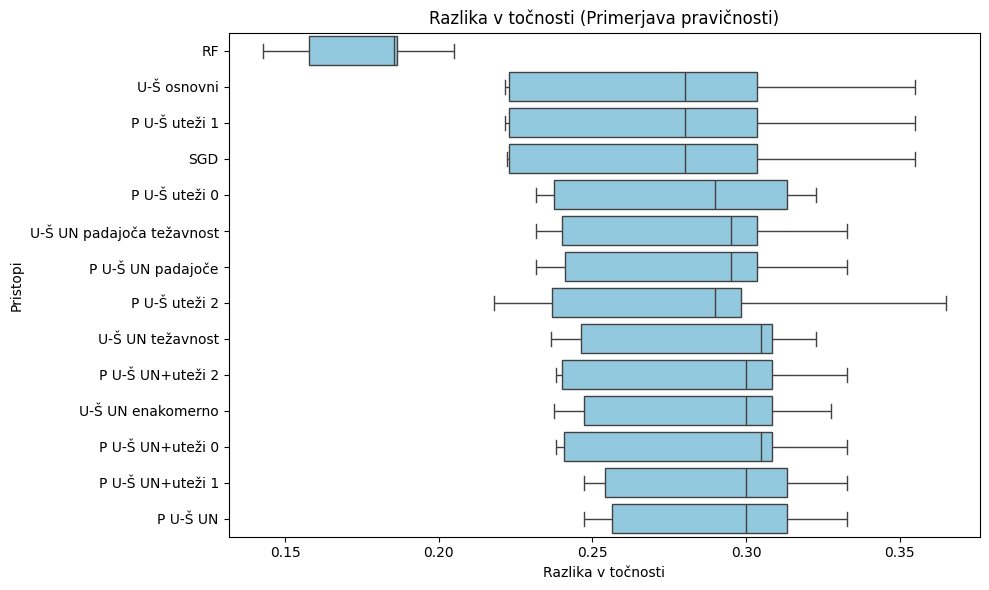

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|RF|0.1427; 0.1579; 0.2050; 0.1853; 0.1865|0.1755|0.1853|0.1427|0.2050|
|U-Š osnovni|0.2228; 0.2216; 0.3550; 0.2800; 0.3035|0.2766|0.2800|0.2216|0.3550|
|P U-Š uteži 1|0.2228; 0.2216; 0.3550; 0.2800; 0.3035|0.2766|0.2800|0.2216|0.3550|
|SGD|0.2228; 0.2222; 0.3550; 0.2800; 0.3035|0.2767|0.2800|0.2222|0.3550|
|P U-Š uteži 0|0.2315; 0.2376; 0.3227; 0.2900; 0.3134|0.2791|0.2900|0.2315|0.3227|
|U-Š UN padajoča težavnost|0.2315; 0.2401; 0.3327; 0.2950; 0.3035|0.2806|0.2950|0.2315|0.3327|
|P U-Š UN padajoče|0.2315; 0.2409; 0.3327; 0.2950; 0.3035|0.2807|0.2950|0.2315|0.3327|
|P U-Š uteži 2|0.2179; 0.2369; 0.3650; 0.2900; 0.2985|0.2817|0.2900|0.2179|0.3650|
|U-Š UN težavnost|0.2364; 0.2461; 0.3227; 0.3050; 0.3085|0.2838|0.3050|0.2364|0.3227|
|P U-Š UN+uteži 2|0.2383; 0.2401; 0.3327; 0.3000; 0.3085|0.2839|0.3000|0.2383|0.3327|
|U-Š UN enakomerno|0.2377; 0.2472; 0.3277; 0.3000; 0.3085|0.2842|0.3000|0.2377|0.32

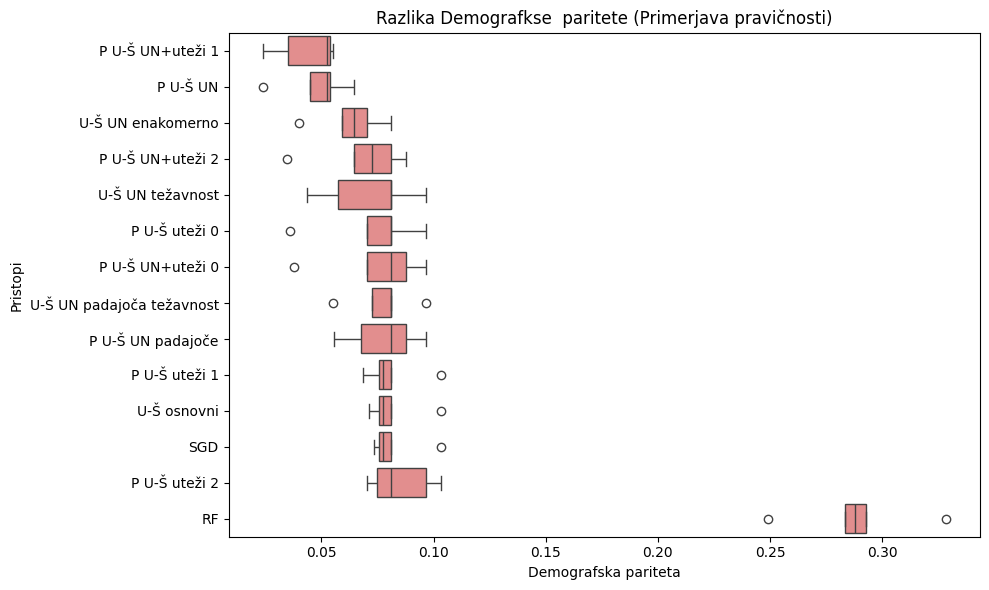

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|P U-Š UN+uteži 1|0.0541; 0.0550; 0.0526; 0.0350; 0.0240|0.0441|0.0526|0.0240|0.0550|
|P U-Š UN|0.0541; 0.0450; 0.0526; 0.0645; 0.0238|0.0480|0.0526|0.0238|0.0645|
|U-Š UN enakomerno|0.0811; 0.0594; 0.0702; 0.0645; 0.0402|0.0631|0.0645|0.0402|0.0811|
|P U-Š UN+uteži 2|0.0811; 0.0727; 0.0877; 0.0645; 0.0346|0.0681|0.0727|0.0346|0.0877|
|U-Š UN težavnost|0.0811; 0.0572; 0.0811; 0.0968; 0.0435|0.0719|0.0811|0.0435|0.0968|
|P U-Š uteži 0|0.0811; 0.0705; 0.0811; 0.0968; 0.0362|0.0731|0.0811|0.0362|0.0968|
|P U-Š UN+uteži 0|0.0811; 0.0702; 0.0877; 0.0968; 0.0378|0.0747|0.0811|0.0378|0.0968|
|U-Š UN padajoča težavnost|0.0811; 0.0727; 0.0811; 0.0968; 0.0553|0.0774|0.0811|0.0553|0.0968|
|P U-Š UN padajoče|0.0811; 0.0677; 0.0877; 0.0968; 0.0555|0.0778|0.0811|0.0555|0.0968|
|P U-Š uteži 1|0.0811; 0.0755; 0.1034; 0.0774; 0.0686|0.0812|0.0774|0.0686|0.1034|
|U-Š osnovni|0.0811; 0.0755; 0.1034; 0.0774; 0.0713|0.0

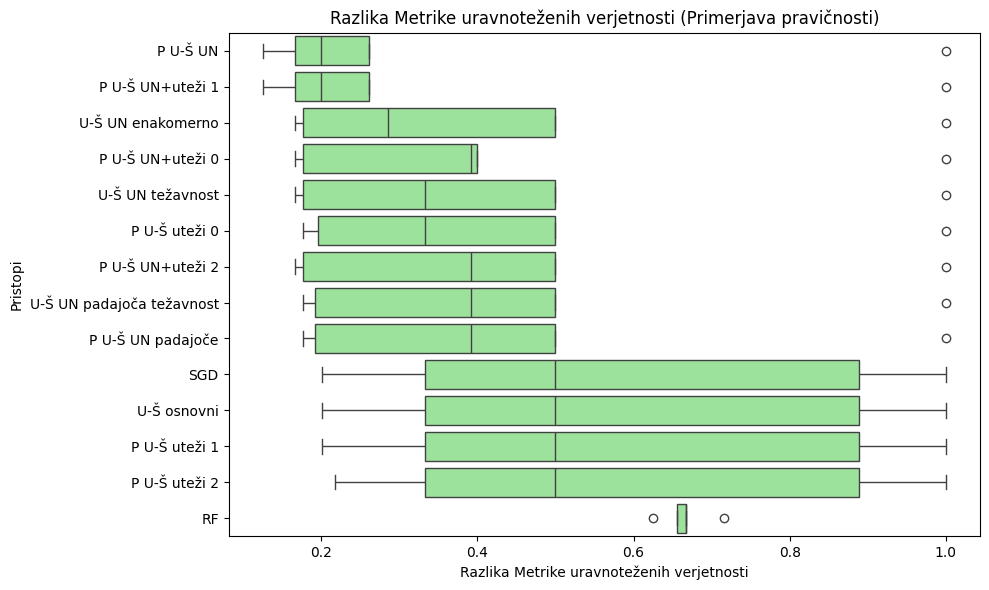

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|P U-Š UN|0.1667; 0.2000; 0.2609; 1.0000; 0.1250|0.3505|0.2000|0.1250|1.0000|
|P U-Š UN+uteži 1|0.1667; 0.2000; 0.2609; 1.0000; 0.1250|0.3505|0.2000|0.1250|1.0000|
|U-Š UN enakomerno|0.1667; 0.5000; 0.2857; 1.0000; 0.1765|0.4258|0.2857|0.1667|1.0000|
|P U-Š UN+uteži 0|0.1667; 0.4000; 0.3913; 1.0000; 0.1765|0.4269|0.3913|0.1667|1.0000|
|U-Š UN težavnost|0.1667; 0.5000; 0.3333; 1.0000; 0.1765|0.4353|0.3333|0.1667|1.0000|
|P U-Š uteži 0|0.1955; 0.5000; 0.3333; 1.0000; 0.1765|0.4411|0.3333|0.1765|1.0000|
|P U-Š UN+uteži 2|0.1667; 0.5000; 0.3913; 1.0000; 0.1765|0.4469|0.3913|0.1667|1.0000|
|U-Š UN padajoča težavnost|0.1923; 0.5000; 0.3913; 1.0000; 0.1765|0.4520|0.3913|0.1765|1.0000|
|P U-Š UN padajoče|0.1923; 0.5000; 0.3913; 1.0000; 0.1765|0.4520|0.3913|0.1765|1.0000|
|SGD|0.3333; 0.5000; 0.8889; 1.0000; 0.2013|0.5847|0.5000|0.2013|1.0000|
|U-Š osnovni|0.3333; 0.5000; 0.8889; 1.0000; 0.2013|0.5847|0.5000

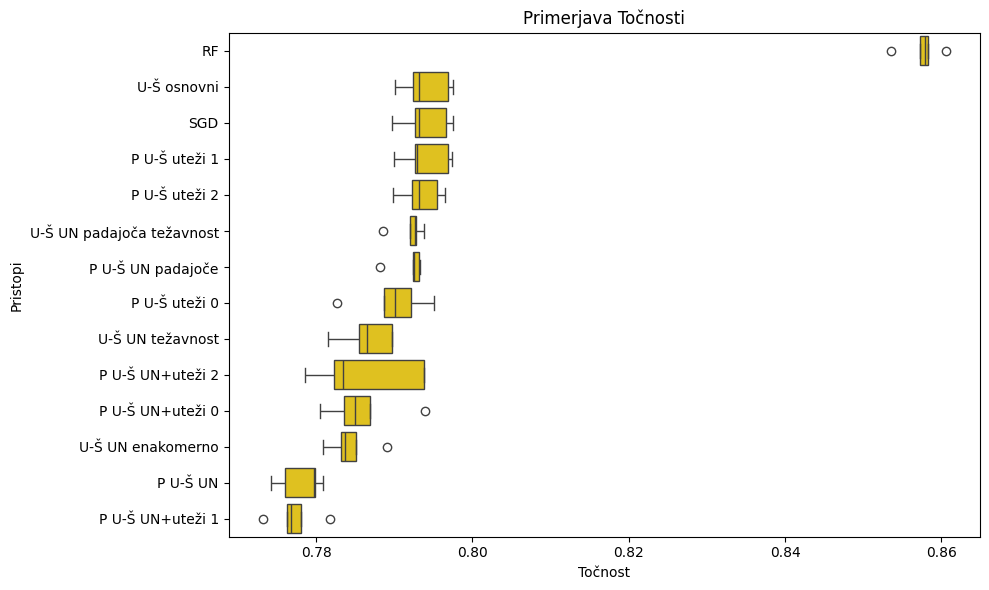

|Model|Vrednosti (K-fold)|Povprečje|Mediana|Minimum|Maksimum|
|---|---|---|---|---|---|
|RF|0.8535; 0.8572; 0.8606; 0.8583; 0.8579|0.8575|0.8579|0.8535|0.8606|
|U-Š osnovni|0.7902; 0.7968; 0.7975; 0.7932; 0.7924|0.7940|0.7932|0.7902|0.7975|
|SGD|0.7897; 0.7966; 0.7975; 0.7932; 0.7927|0.7939|0.7932|0.7897|0.7975|
|P U-Š uteži 1|0.7899; 0.7968; 0.7974; 0.7929; 0.7926|0.7939|0.7929|0.7899|0.7974|
|P U-Š uteži 2|0.7898; 0.7955; 0.7965; 0.7923; 0.7932|0.7935|0.7932|0.7898|0.7965|
|U-Š UN padajoča težavnost|0.7885; 0.7938; 0.7928; 0.7920; 0.7926|0.7919|0.7926|0.7885|0.7938|
|P U-Š UN padajoče|0.7882; 0.7933; 0.7931; 0.7924; 0.7925|0.7919|0.7925|0.7882|0.7933|
|P U-Š uteži 0|0.7887; 0.7951; 0.7901; 0.7922; 0.7827|0.7898|0.7901|0.7827|0.7951|
|U-Š UN težavnost|0.7816; 0.7897; 0.7897; 0.7855; 0.7865|0.7866|0.7865|0.7816|0.7897|
|P U-Š UN+uteži 2|0.7786; 0.7937; 0.7938; 0.7835; 0.7822|0.7864|0.7835|0.7786|0.7938|
|P U-Š UN+uteži 0|0.7805; 0.7869; 0.7939; 0.7849; 0.7836|0.7860|0.7849|0.7805|0.793

In [ ]:
# Instantiate the fairness evaluator
evaluator = FairnessEvaluatorHelper(folds, predictions)

# Compute all fairness metrics
evaluator.compute_fairness_metrics()

# Plot sorted fairness metrics
evaluator.plot_accuracy_differences()
evaluator.plot_demographic_parity()
evaluator.plot_equalized_odds()
evaluator.plot_accuracies()

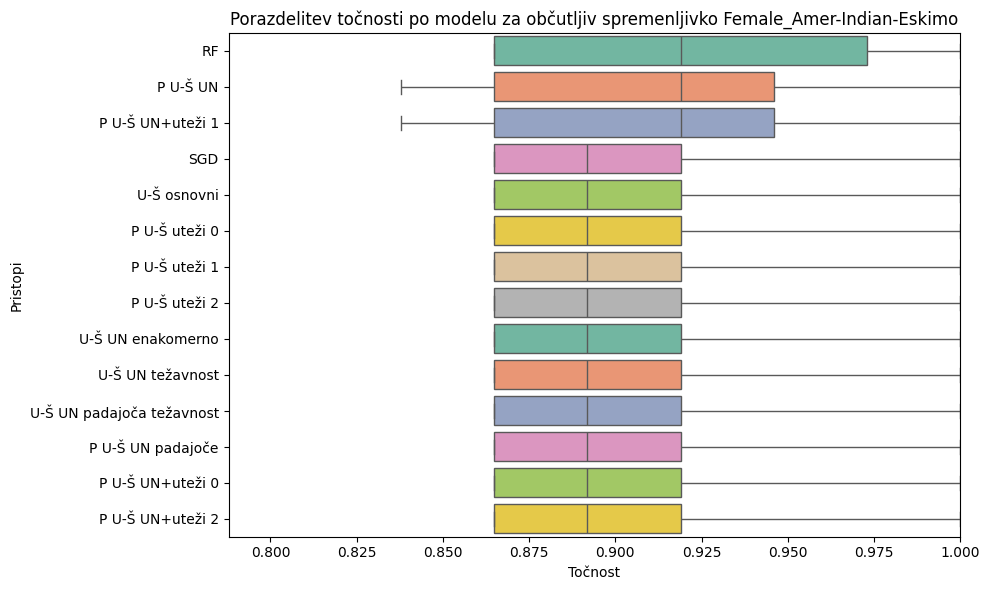

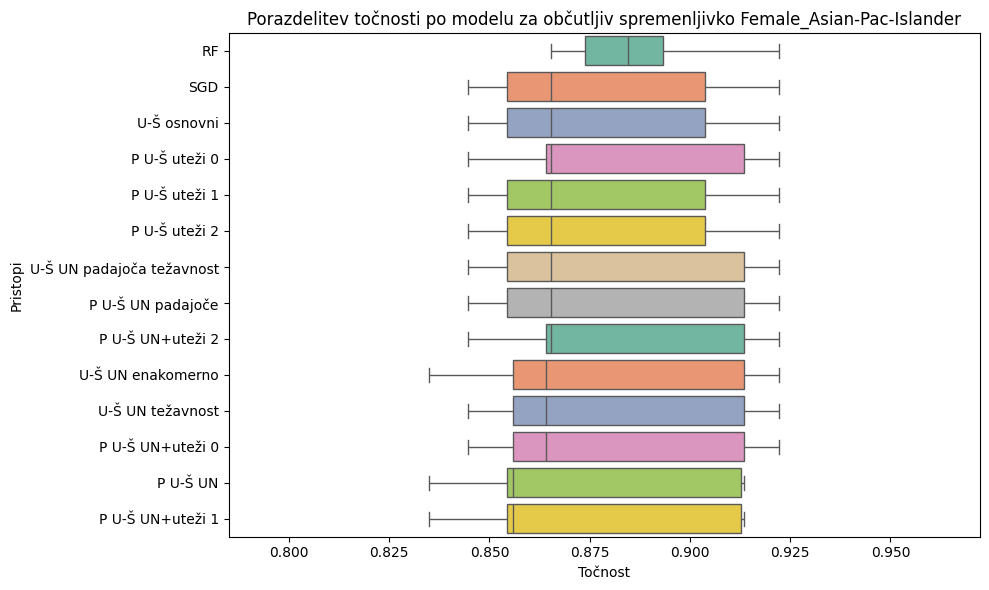

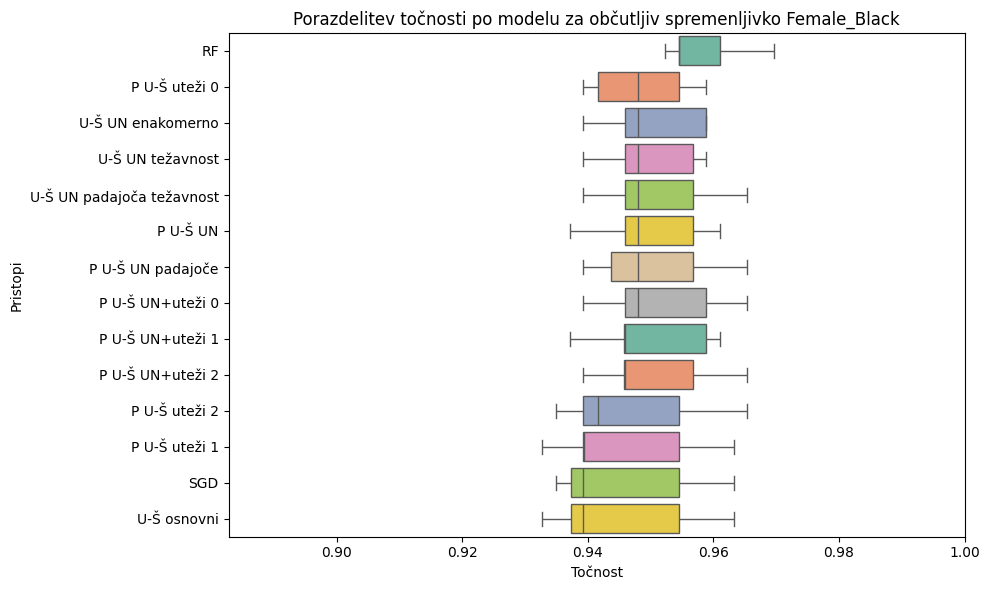

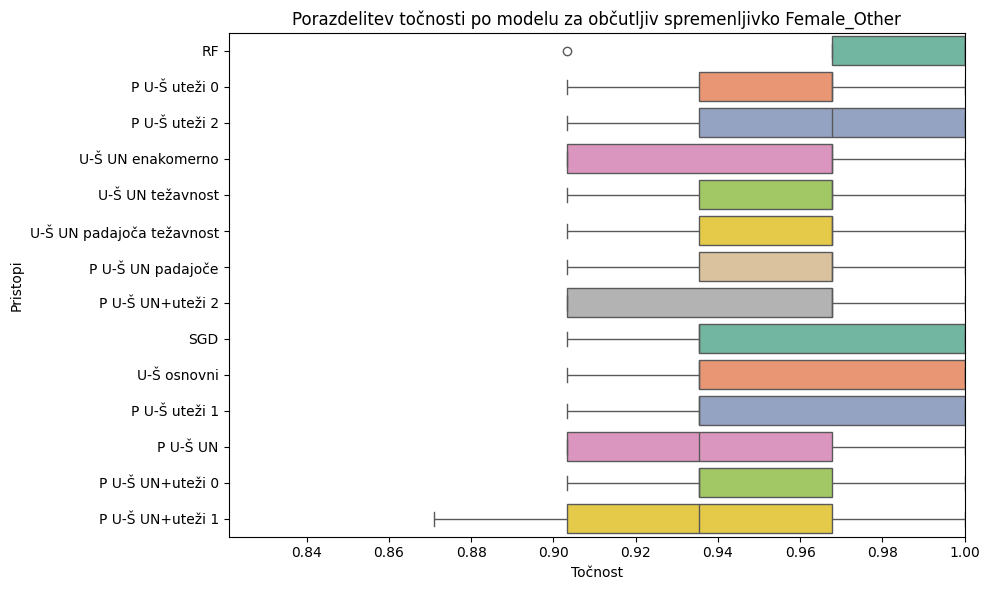

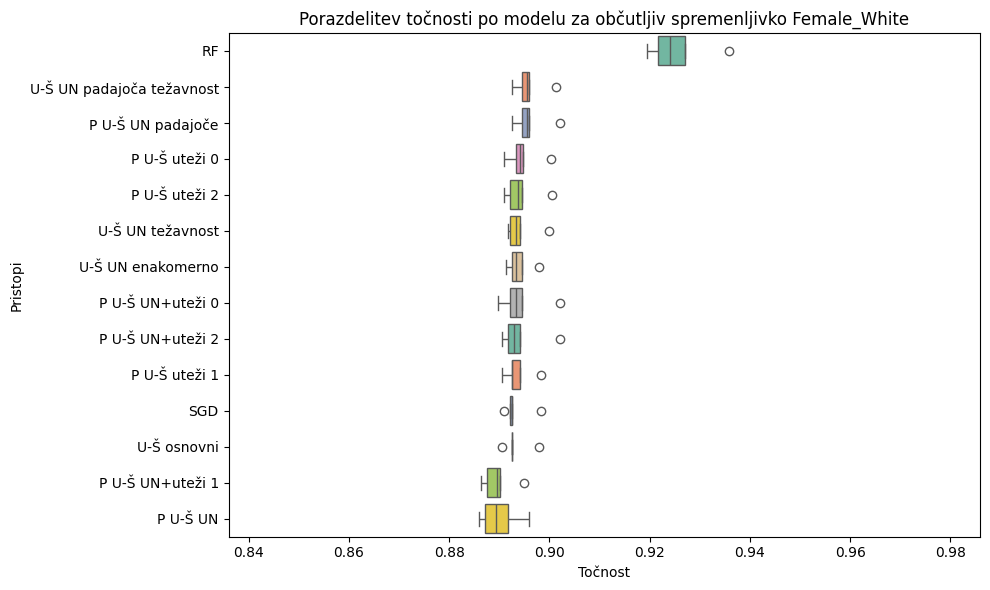

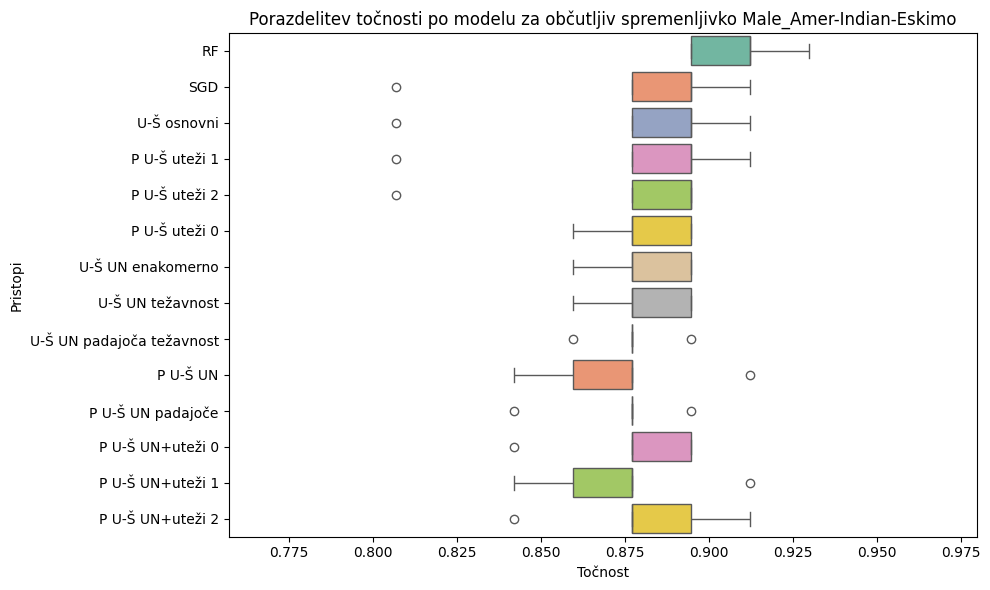

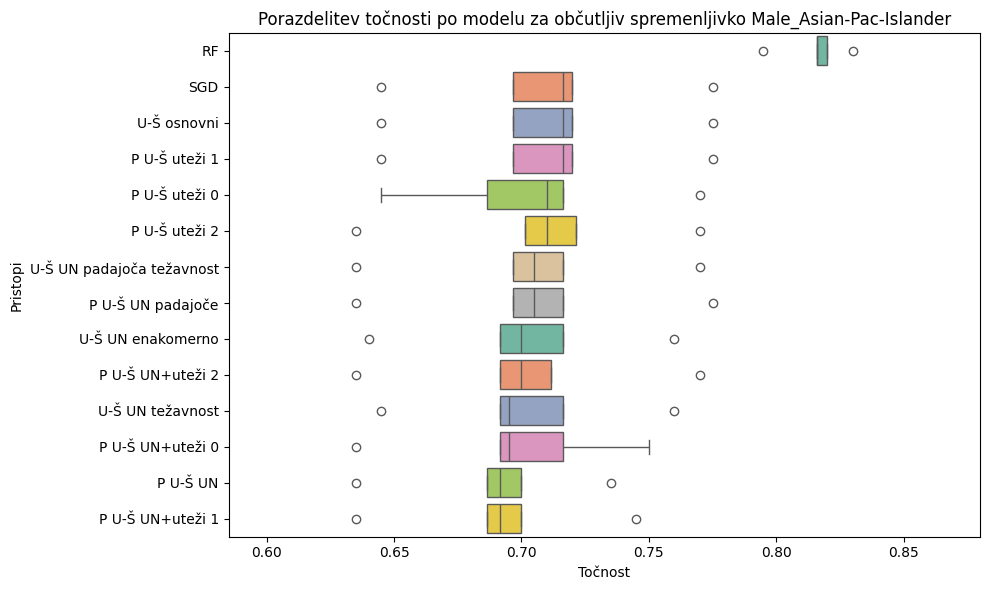

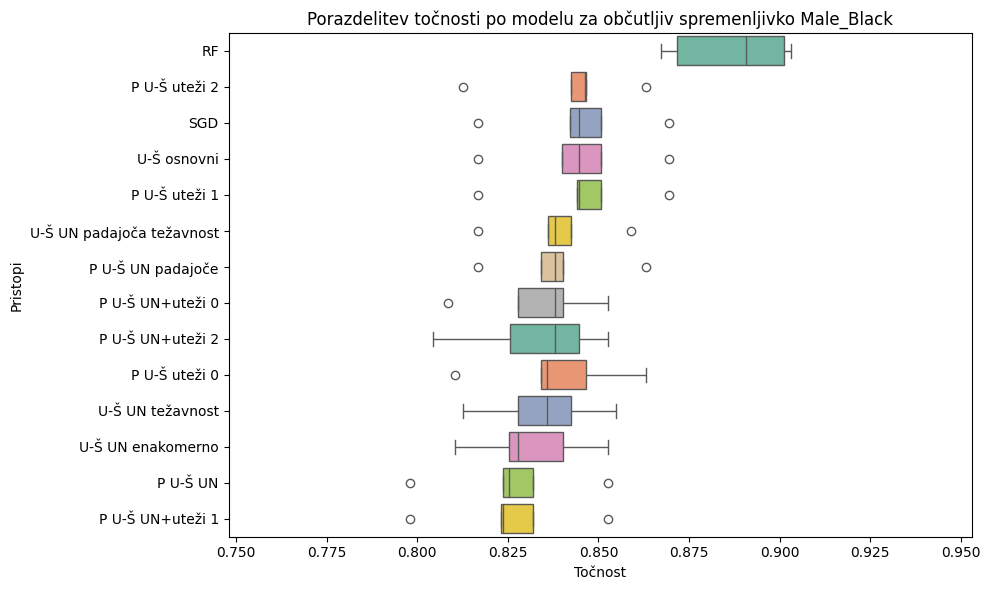

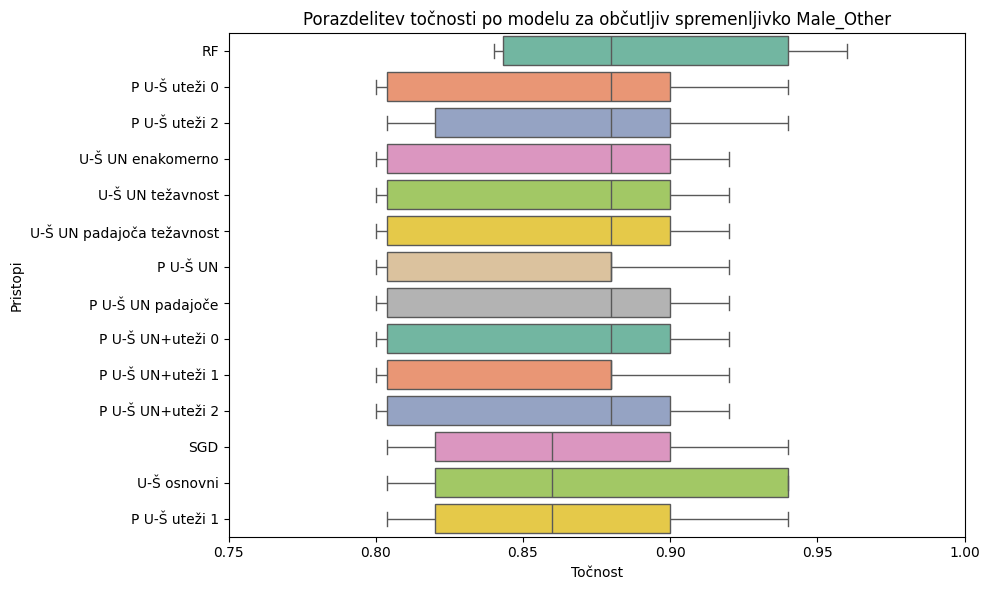

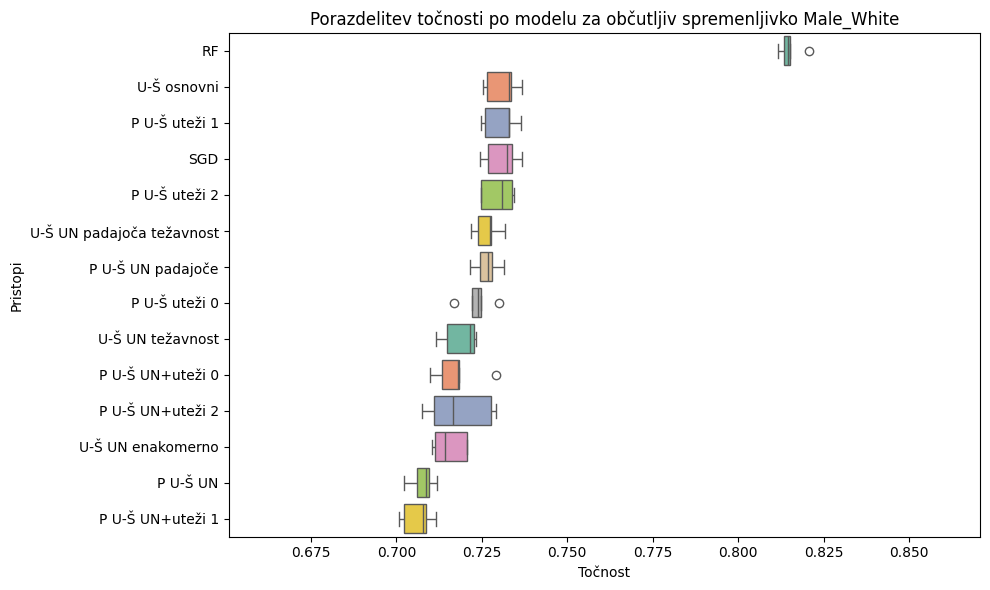

In [105]:
# Plot per-group accuracy distributions
evaluator.plot_group_accuracies(label_encoder=label_encoders['gender_race'])

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_categorical_distribution(
    df: pd.DataFrame,
    column: str = "gender_race",
    title: str | None = None,
    sort: str = "desc",   # "desc", "asc", or "index"
    annotate: bool = True
):
    """
    Plot a horizontal bar chart for the value distribution of a categorical column.

    Parameters
    ----------
    df : pandas.DataFrame
        Your dataframe.
    column : str
        Name of the categorical column to plot.
    title : str | None
        Custom title. If None, a title is generated automatically.
    sort : {"desc", "asc", "index"}
        Sort bars by count (descending/ascending) or by category index.
    annotate : bool
        Whether to show count and percentage labels on bars.

    Returns
    -------
    matplotlib.axes.Axes
        The Axes object for further customization if needed.
    """
    counts = df[column].value_counts(dropna=False)

    if sort == "asc":
        counts = counts.sort_values(ascending=True)
    elif sort == "index":
        counts = counts.sort_index()
    else:
        counts = counts.sort_values(ascending=False)

    total = counts.sum()
    # Dynamic height so long lists don't get cramped
    height = max(4, 0.45 * len(counts) + 1)

    fig, ax = plt.subplots(figsize=(12, height))
    bars = ax.barh(range(len(counts)), counts.values)  # no specific colors

    # y-tick labels
    labels = [str(idx) if pd.notna(idx) else "NaN" for idx in counts.index]
    ax.set_yticks(range(len(counts)))
    ax.set_yticklabels(labels)

    # Put the largest at the top if sorted by count desc
    if sort == "desc":
        ax.invert_yaxis()

    ax.set_xlabel("Count")
    ax.set_ylabel(column)
    ax.set_title(title or f"Distribution of '{column}'")

    if annotate:
        for i, val in enumerate(counts.values):
            pct = val / total if total else 0
            ax.text(
                val,
                i,
                f" {val} ({pct:.1%})",
                va="center",
                ha="left"
            )
    print(df[column].value_counts())

    plt.tight_layout()
    return ax

gender_race
Male_White                   28735
Female_White                 13027
Male_Black                    2377
Female_Black                  2308
Male_Asian-Pac-Islander       1002
Female_Asian-Pac-Islander      517
Male_Amer-Indian-Eskimo        285
Male_Other                     251
Female_Amer-Indian-Eskimo      185
Female_Other                   155
Name: count, dtype: int64


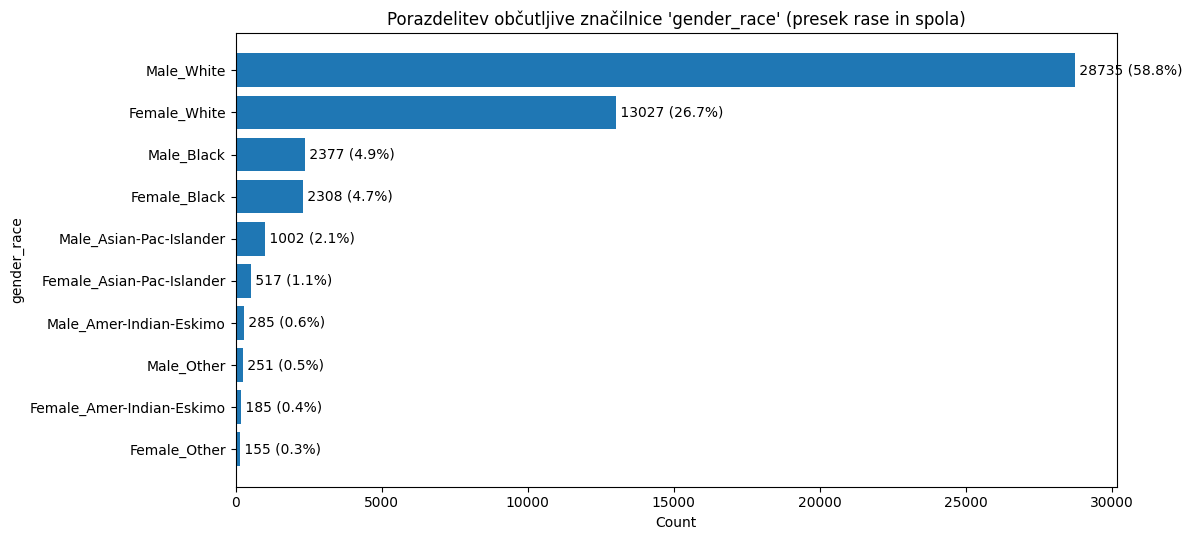

In [31]:
import matplotlib.pyplot as plt
data = fetch_adult(as_frame=True)
df = data.frame
df['gender_race'] = df['sex'].astype(str) + "_" + df['race'].astype(str)
ax = plot_categorical_distribution(
    df,
    column="gender_race",
    title="Porazdelitev občutljive značilnice 'gender_race' (presek rase in spola)"
)
plt.show()

Distribution of 'gender_age_class' sensitive feature:
gender_age_class
Male_35-44      8647
Male_25-34      8408
Male_45-54      6214
Female_25-34    4169
Male_18-24      3878
Female_35-44    3546
Male_55-64      3373
Female_18-24    3097
Female_45-54    2557
Female_55-64    1409
Male_65+        1395
Male_0-17        735
Female_0-17      722
Female_65+       692
Name: count, dtype: int64
gender_age_class
Male_35-44      8647
Male_25-34      8408
Male_45-54      6214
Female_25-34    4169
Male_18-24      3878
Female_35-44    3546
Male_55-64      3373
Female_18-24    3097
Female_45-54    2557
Female_55-64    1409
Male_65+        1395
Male_0-17        735
Female_0-17      722
Female_65+       692
Name: count, dtype: int64


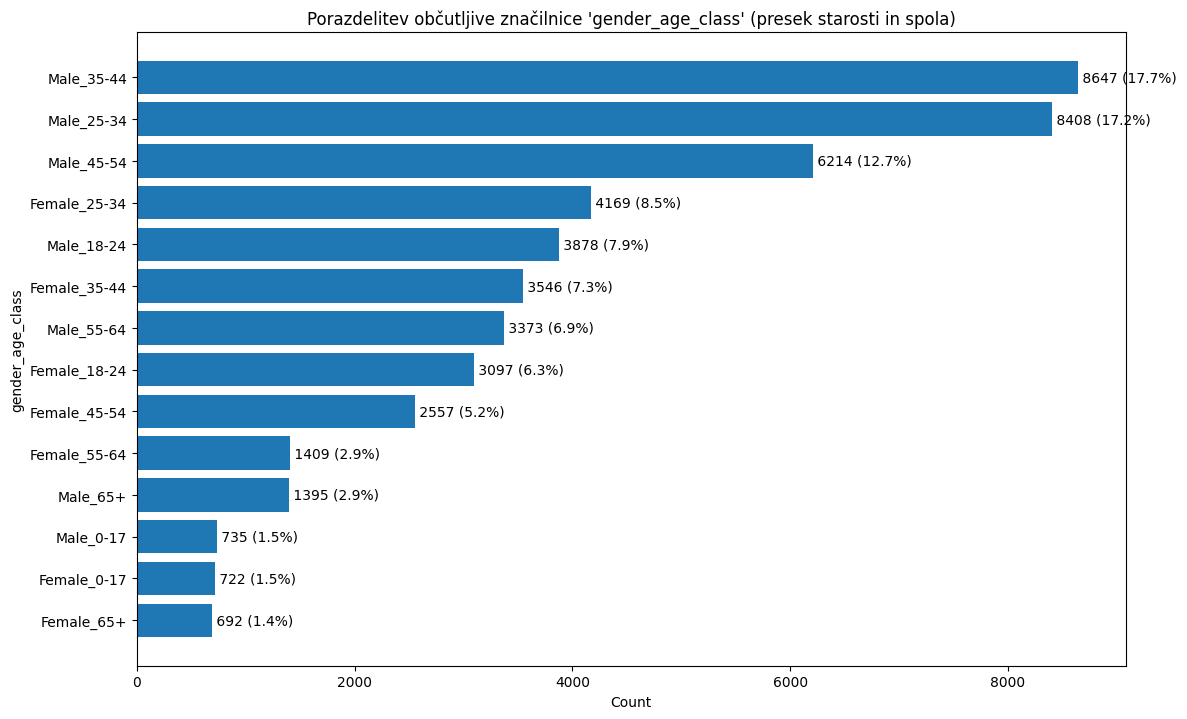

In [32]:
# Create 'age_class' column
df['age_class'] = pd.cut(df['age'], bins=[0, 18, 24, 34, 44, 54, 64, float('inf')],
                         labels=['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])


df['gender_age_class'] = df['sex'].astype(str) + "_" + df['age_class'].astype(str)

# To confirm the sensitive feature, you can check the distribution of the combined sensitive feature
print("Distribution of 'gender_age_class' sensitive feature:")
print(df['gender_age_class'].value_counts())

ax = plot_categorical_distribution(
    df,
    column="gender_age_class",
    title="Porazdelitev občutljive značilnice 'gender_age_class' (presek starosti in spola)"
)
plt.show()

age_class
25-34    12577
35-44    12193
45-54     8771
18-24     6975
55-64     4782
65+       2087
0-17      1457
Name: count, dtype: int64


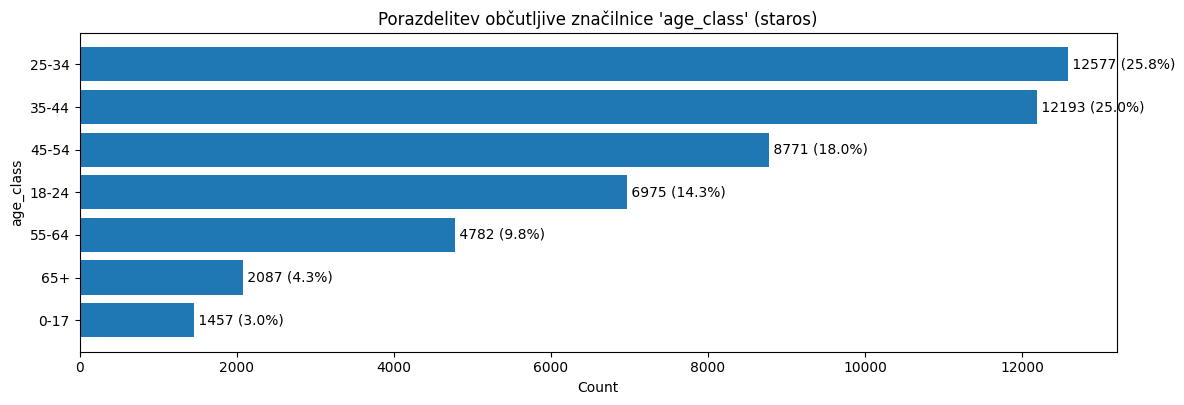

In [33]:
ax = plot_categorical_distribution(
    df,
    column="age_class",
    title="Porazdelitev občutljive značilnice 'age_class' (staros)"
)
plt.show()

race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64


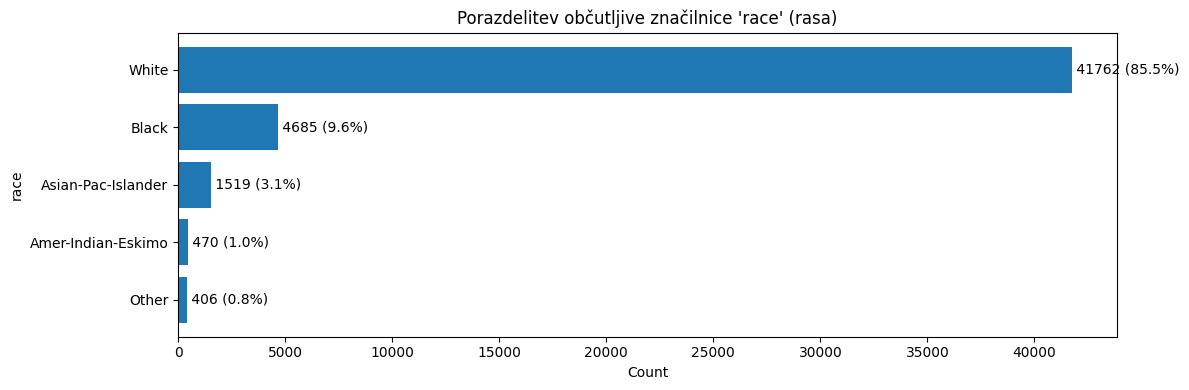

In [34]:
ax = plot_categorical_distribution(
    df,
    column="race",
    title="Porazdelitev občutljive značilnice 'race' (rasa)"
)
plt.show()